# ZECMIP Natural Variability ALL VARIABLES

Assessing if the ZEC values are outside the range of natural variability
Current variables: tas, pr

In [1]:
from glob import glob
import os, sys
from functools import partial
import json

from pprint import pprint

import xarray as xr
import pandas as pd
import numpy as np

import cftime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap

import pymannkendall

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import open_zecmip
import utils
import warnings
warnings.filterwarnings('ignore')
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe

import drift_functions
import sn_plotting
import zecmip_plotting
import plotting_functions as pf

from importlib import reload
from typing import List, Any, Callable, Union, Tuple, Optional
from numpy.typing import ArrayLike
from matplotlib.axes import Axes

# from listXarray import listXarray
import cartopy.feature as cf

logger = utils.get_notebook_logger()

Matplotlib created a temporary config/cache directory at /jobfs/111231641.gadi-pbs/matplotlib-4mpjupb8 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from scipy.stats import ks_2samp,ttest_ind, levene, bartlett, f_oneway, kruskal
import scipy.stats
import stats
np.set_printoptions(precision=2, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [3]:
import zec_calculation_functions

In [4]:
# import listXarray as lxr
# reload(lxr)
from listXarray import listXarray

In [5]:
# client.close()

In [6]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:44041
-   dashboard at:        /proxy/36171/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:34103'
-         Start Nanny at: 'tcp://127.0.0.1:33219'
-         Start Nanny at: 'tcp://127.0.0.1:36819'
-         Start Nanny at: 'tcp://127.0.0.1:46881'
-         Start Nanny at: 'tcp://127.0.0.1:37685'
-         Start Nanny at: 'tcp://127.0.0.1:41425'
-         Start Nanny at: 'tcp://127.0.0.1:39721'
- Register worker <WorkerState 'tcp://127.0.0.1:32821', name: 4, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:32821
- Starting established connection to tcp://127.0.0.1:36152
- Register worker <WorkerState 'tcp://127.0.0.1:42717', name: 6, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:42717
- Starting established connection to tcp://127.0.0.1:36164
- Register worker <WorkerState 'tcp://127.0.0.1:37695', name: 2, status

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36171/status,
Dashboard: /proxy/36171/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44041,Workers: 7
Dashboard: /proxy/36171/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:33759,Total threads: 4
Dashboard: /proxy/35957/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:34103,


In [7]:
variable = 'tas' #pr' #'tas'

In [8]:
VARIABLE_CONTROL_MAP = {
    'tas':{'xlabel': r'Temperature Anomaly ($^\circ C$)', 'cmap':'RdBu_r', 'relative_difference':False},
    'pr': {'xlabel': 'Precipitation Anomaly (mm/day)', 'cmap':'BrBG', 'relative_difference':False}}

In [9]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [10]:
a1_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1000pgc', variable, chunks=chunks,
                                                           logginglevel='INFO').to_dataarray(variable).sort_by_refkey()

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191206/*.nc
0.3.0
- CanESM5
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
-      r3i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r2i1p2f1/Amon/tas/gn/v20190429/*.nc
-      r4i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r3i1p2f1/Amon/tas/gn/v20190429/*.nc
-      r5i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r5i1p2f1/Amon/tas/gn/v20190429/*.nc
-      r2i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKE

In [11]:
pct_raw_xrlist =  (open_zecmip.extract_experiment_into_xrlist('1pct', variable, logginglevel='ERROR', chunks=chunks)
                   .to_dataarray(variable)
                   .sort_by_refkey())

In [12]:
# pi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('picontrol', variable, logginglevel='INFO')
#                     .to_dataarray(variable).sort_by_refkey().rename({'latitude':'lat', 'longitude': 'lon'})).isel(ensemble=0)

In [127]:
# Two version - esm-piControl and picontrol
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('picontrol', variable, logginglevel='INFO', chunks=chunks)
                    .to_dataarray(variable).sort_by_refkey().rename({'latitude':'lat', 'longitude': 'lon'})).isel(ensemble=0)

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v2

In [14]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

In [100]:
a1_raw_xrlist['CanESM5'].ensemble.values, pct_raw_xrlist['CanESM5'].ensemble.values

(array(['r1i1p2f1', 'r3i1p2f1', 'r2i1p2f1'], dtype='<U8'),
 array(['r1i1p2f1', 'r2i1p2f1', 'r3i1p2f1'], dtype='<U8'))

In [108]:
# All of the ensemble members for the 1% CO2 match the ensemble members for the A1 experiment
all(
    np.concatenate(
        [np.sort(a1_raw_xrlist[model].ensemble.values) == np.sort(pct_raw_xrlist[model].ensemble.values)
         for model in a1_raw_xrlist.refkeys]))

True

In [119]:
# All of the ensemble members for the 1% CO2 match the ensemble members for the A1 experiment
all([
    str(esmpi_raw_xrlist[model].ensemble.values) in a1_raw_xrlist[model].ensemble.values
         for model in a1_raw_xrlist.refkeys])

False

In [125]:
# Checking that there is a match between the a1 and the piControl
for model in a1_raw_xrlist.refkeys:
    ensemble_match_bool = str(esmpi_raw_xrlist[model].ensemble.values) in a1_raw_xrlist[model].ensemble.values
    if not ensemble_match_bool: print(model) 

CanESM5


In [126]:
a1_raw_xrlist['CanESM5'].ensemble.values, esmpi_raw_xrlist['CanESM5'].ensemble.values

(array(['r1i1p2f1', 'r3i1p2f1', 'r2i1p2f1'], dtype='<U8'),
 array('r1i1p1f1', dtype='<U8'))

In [93]:
a1_raw_xrlist.dim('ensemble', output='dict')

{'ACCESS-ESM1-5': array(['r1i1p1f1'], dtype='<U8'),
 'CESM2': array(['r1i1p1f1'], dtype='<U8'),
 'CanESM5': array(['r1i1p2f1', 'r3i1p2f1', 'r2i1p2f1'], dtype='<U8'),
 'GFDL-ESM4': array(['r1i1p1f1'], dtype='<U8'),
 'GISS-E2-1-G-CC': array(['r1i1p1f1'], dtype='<U8'),
 'MIROC-ES2L': array(['r1i1p1f2'], dtype='<U8'),
 'MPI-ESM1-2-LR': array(['r1i1p1f1'], dtype='<U8'),
 'NorESM2-LM': array(['r1i1p1f1'], dtype='<U8'),
 'UKESM1-0-LL': array(['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2'], dtype='<U8')}

In [16]:
pct_raw_xrlist.dim('ensemble')

ACCESS-ESM1-5 - ['r1i1p1f1']
CESM2 - ['r1i1p1f1']
CanESM5 - ['r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1']
GFDL-ESM4 - ['r1i1p1f1']
GISS-E2-1-G-CC - ['r1i1p1f1']
MIROC-ES2L - ['r1i1p1f2']
MPI-ESM1-2-LR - ['r1i1p1f1']
NorESM2-LM - ['r1i1p1f1']
UKESM1-0-LL - ['r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2']


In [17]:
if variable == 'tas':
    # Convert to celcius
    print('Convert to Celcius')
    a1_raw_xrlist = a1_raw_xrlist - 273.15
    pct_raw_xrlist = pct_raw_xrlist - 273.15
    esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15
elif variable == 'pr':
    print('Convert to mm')
    a1_raw_xrlist = a1_raw_xrlist * 86400
    pct_raw_xrlist = pct_raw_xrlist * 86400
    esmpi_raw_xrlist = esmpi_raw_xrlist * 86400

Convert to Celcius


In [18]:
pct_raw_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 145, 'lon': 192})
CESM2         ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
CanESM5       ({'ensemble': 3, 'model': 1, 'time': 1812, 'lat': 64, 'lon': 128})
GFDL-ESM4     ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC({'ensemble': 1, 'model': 1, 'time': 1812, 'lat': 90, 'lon': 144})
MIROC-ES2L    ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR ({'ensemble': 1, 'model': 1, 'time': 1980, 'lat': 96, 'lon': 192})
NorESM2-LM    ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 96, 'lon': 144})
UKESM1-0-LL   ({'ensemble': 4, 'model': 1, 'time': 1800, 'lat': 144, 'lon': 192})

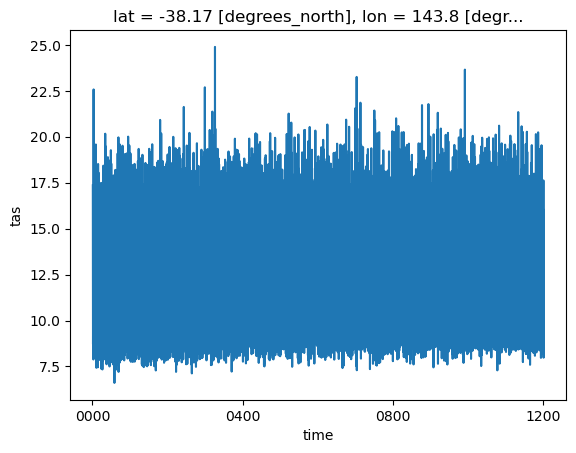

In [19]:
esmpi_raw_xrlist[1].sel(lat=-38, lon=144, method='nearest').plot()

In [20]:
esmpi_xrlist = esmpi_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
pct_xrlist = pct_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
a1_xrlist = a1_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')

In [21]:
# The global weighted mean
pct_smean_xrlist = pct_xrlist.apply(sn.calculate_global_value, variable)
a1_smean_xrlist = a1_xrlist.apply(sn.calculate_global_value, variable)
esmpi_smean_xrlist = esmpi_xrlist.apply(sn.calculate_global_value, variable)

In [22]:
# pct_smean_xrlist = pct_smean_xrlist.compute()
# a1_smean_xrlist = a1_smean_xrlist.compute()
# esmpi_smean_xrlist = esmpi_smean_xrlist.compute()

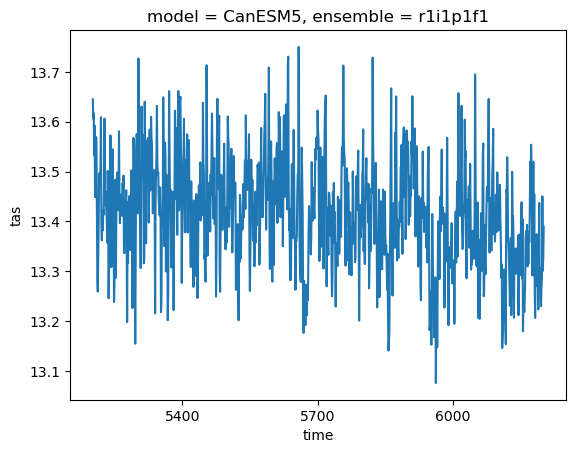

In [23]:
esmpi_smean_xrlist['CanESM5'].plot()

In [24]:
# # Can see this in the global mean time series. But this has errors after 1000
# esmpi_xrlist['CanESM5'] = esmpi_xrlist['CanESM5'].isel(time=slice(None, 1000))

In [25]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray(
    [zec_calculation_functions.calculate_branch_average(pct_smean_xrlist[model], a1_smean_xrlist[model], logginglevel='DEBUG')
     for model in pct_smean_xrlist.refkeys], key_dim='model')

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- Time values around branch point: 20
- [cftime.DatetimeProlepticGregorian(158, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(159, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(160, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(161, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(162, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(163, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(164, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(165, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(166, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(167, 12, 31, 0, 0, 0, 0, has_year_zero=True

In [26]:
branch_point_mean_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'ensemble': 1, 'model': 1})
CESM2         ({'ensemble': 1, 'model': 1})
CanESM5       ({'ensemble': 3, 'model': 1})
GFDL-ESM4     ({'ensemble': 1, 'model': 1})
GISS-E2-1-G-CC({'ensemble': 1, 'model': 1})
MIROC-ES2L    ({'ensemble': 1, 'model': 1})
MPI-ESM1-2-LR ({'ensemble': 1, 'model': 1})
NorESM2-LM    ({'ensemble': 1, 'model': 1})
UKESM1-0-LL   ({'ensemble': 4, 'model': 1})

In [27]:
#branch_point_mean_xrlist = branch_point_mean_xrlist.set_refkeys('model')

In [28]:
pct_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'ensemble': 1, 'model': 1, 'time': 150})
CESM2         ({'ensemble': 1, 'model': 1, 'time': 150})
CanESM5       ({'ensemble': 3, 'model': 1, 'time': 151})
GFDL-ESM4     ({'ensemble': 1, 'model': 1, 'time': 150})
GISS-E2-1-G-CC({'ensemble': 1, 'model': 1, 'time': 151})
MIROC-ES2L    ({'ensemble': 1, 'model': 1, 'time': 150})
MPI-ESM1-2-LR ({'ensemble': 1, 'model': 1, 'time': 165})
NorESM2-LM    ({'ensemble': 1, 'model': 1, 'time': 150})
UKESM1-0-LL   ({'ensemble': 4, 'model': 1, 'time': 150})

In [29]:
# The branch point may also be at the year 70. Checking if this is the case
branch_point_70yr_mean_xrlist = pct_smean_xrlist.isel(time=slice(60, 80)).mean(dim='time')

In [30]:
# Just confirming that these are indeed the correct values to use
np.take(pct_smean_xrlist[1].time.values, [0, 70])

array([cftime.DatetimeNoLeap(1, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(71, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [31]:
# This should be 20 years long
len(pct_smean_xrlist[1].isel(time=slice(60, 80)).time.values)

20

In [32]:
# Should be 10 years either side
np.take(pct_smean_xrlist[1].isel(time=slice(60, 80)).time.values, [0, -1])

array([cftime.DatetimeNoLeap(61, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(80, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [33]:
branch_point_mean_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'ensemble': 1, 'model': 1})
CESM2         ({'ensemble': 1, 'model': 1})
CanESM5       ({'ensemble': 3, 'model': 1})
GFDL-ESM4     ({'ensemble': 1, 'model': 1})
GISS-E2-1-G-CC({'ensemble': 1, 'model': 1})
MIROC-ES2L    ({'ensemble': 1, 'model': 1})
MPI-ESM1-2-LR ({'ensemble': 1, 'model': 1})
NorESM2-LM    ({'ensemble': 1, 'model': 1})
UKESM1-0-LL   ({'ensemble': 4, 'model': 1})

In [34]:
a1_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'ensemble': 1, 'model': 1, 'time': 101})
CESM2         ({'ensemble': 1, 'model': 1, 'time': 150})
CanESM5       ({'ensemble': 3, 'model': 1, 'time': 100})
GFDL-ESM4     ({'ensemble': 1, 'model': 1, 'time': 200})
GISS-E2-1-G-CC({'ensemble': 1, 'model': 1, 'time': 180})
MIROC-ES2L    ({'ensemble': 1, 'model': 1, 'time': 248})
MPI-ESM1-2-LR ({'ensemble': 1, 'model': 1, 'time': 185})
NorESM2-LM    ({'ensemble': 1, 'model': 1, 'time': 100})
UKESM1-0-LL   ({'ensemble': 4, 'model': 1, 'time': 330})

In [35]:
type(a1_smean_xrlist)

listXarray.listXarray

In [36]:
type(branch_point_mean_xrlist)

listXarray.listXarray

In [37]:
a1_smean_xrlist - branch_point_mean_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'ensemble': 1, 'model': 1, 'time': 101})
CESM2         ({'ensemble': 1, 'model': 1, 'time': 150})
CanESM5       ({'ensemble': 3, 'model': 1, 'time': 100})
GFDL-ESM4     ({'ensemble': 1, 'model': 1, 'time': 200})
GISS-E2-1-G-CC({'ensemble': 1, 'model': 1, 'time': 180})
MIROC-ES2L    ({'ensemble': 1, 'model': 1, 'time': 248})
MPI-ESM1-2-LR ({'ensemble': 1, 'model': 1, 'time': 185})
NorESM2-LM    ({'ensemble': 1, 'model': 1, 'time': 100})
UKESM1-0-LL   ({'ensemble': 4, 'model': 1, 'time': 330})

In [38]:
# if variable == 'tas':3
a1_smean_anom_xrlist = (a1_smean_xrlist - branch_point_mean_xrlist).compute()
# elif variable == 'pr':
    # a1_smean_anom_xrlist = (((a1_smean_xrlist - branch_point_mean_xrlist)*100)/branch_point_mean_xrlist).compute()

In [39]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
# Using isel is fine here as this is JUST THE A1 branch
zec25_xrlist = a1_smean_anom_xrlist.isel(time=slice(15, 35)).mean(dim='time')
zec50_xrlist = a1_smean_anom_xrlist.isel(time=slice(40, 60)).mean(dim='time')

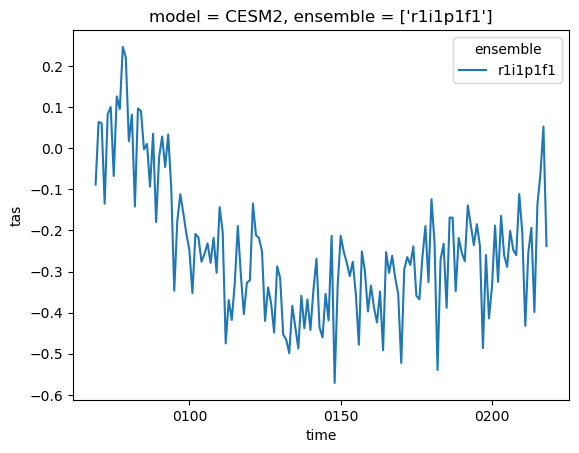

In [40]:
a1_smean_anom_xrlist[1].plot(x='time', hue='ensemble')

In [41]:
zec25_xrlist[2]

<xarray.DataArray 'tas' (ensemble: 3, model: 1)>
-0.01 -0.07211 -0.02207
Coordinates:
  * model     (model) <U7 'CanESM5'
  * ensemble  (ensemble) <U8 'r1i1p2f1' 'r3i1p2f1' 'r2i1p2f1'

# ZEC anomly period analysis

In [42]:
LABEl_MAP = VARIABLE_CONTROL_MAP

In [43]:
variable

'tas'

## Global Values

In [44]:
def calculate_rolling_period_diff(da: xr.DataArray, period:int, relative_difference:str=False, logginglevel:str='ERROR') -> xr.DataArray:
    """
    Calculate the rolling period difference between two slices of a given DataArray.
    Parameters:
        da (xr.DataArray): Input DataArray.
    Returns:
        xr.DataArray: Rolling period difference.
    """
    utils.change_logginglevel(logginglevel)
    # Get the length of the time dimension
    da = da.dropna(dim='time')
    time_length = len(da.time.values)
    logger.info(f'{da.model.values}')
    logger.info(f'{time_length=}')

    
    slice_start = da.isel(time=slice(None, time_length - period))
    slice_end = da.isel(time=slice(period, None))

    logger.info('Time Lengths:')
    logger.info(f'- Start slice - {len(slice_start.time.values)}')
    logger.debug(slice_start.time.values[0])
    logger.info(f'- Final slice - {len(slice_end.time.values)}')
    logger.debug(slice_end.time.values[0])
    logger.debug('End start-slice vs start end-slice offset')
    logger.debug(slice_end.time.dt.year.values[0]-slice_start.time.dt.year.values[0])

    # Calculate the rolling mean with a window size of 20 and drop NA values
    slice_start_rolling = slice_start.rolling(time=20).mean(dim='time').dropna(dim='time')
    slice_end_rolling = slice_end.rolling(time=20).mean(dim='time').dropna(dim='time')
    logger.debug(f'- Start rolling slice - {len(slice_start_rolling.time.values)}')
    logger.debug(f'- Final rolling slice - {len(slice_end_rolling.time.values)}')

    # Calculate the difference between the two rolling means
    diff_np = slice_end_rolling.values - slice_start_rolling.values

    # Calculate the difference as a percentage
    if relative_difference:
        diff_np = (diff_np/slice_start_rolling.values)*100
    
    # Create a new DataArray with the same dimensions as the sliced data
    diff_da = xr.zeros_like(da.isel(time=slice(None, len(slice_end_rolling.time.values))))
    diff_da += diff_np
    
    logger.info('\n')
    return diff_da

In [45]:
esmpi_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'model': 1, 'time': 1000})
CESM2         ({'model': 1, 'time': 1200})
CanESM5       ({'model': 1, 'time': 1400})
GFDL-ESM4     ({'model': 1, 'time': 500})
GISS-E2-1-G-CC({'model': 1, 'time': 165})
MIROC-ES2L    ({'model': 1, 'time': 500})
MPI-ESM1-2-LR ({'model': 1, 'time': 1000})
NorESM2-LM    ({'model': 1, 'time': 501})
UKESM1-0-LL   ({'model': 1, 'time': 1880})

In [46]:
variable, VARIABLE_CONTROL_MAP[variable]['relative_difference']

('tas', False)

The two twenty years have to be seperated by 5 years.
The start points can't just be seperated by 5 years, there must be 5 years between the end of
the first period and the beggining of the next. Thus 20 muts be added to the window.
The period used in the function is just the offset of the two periosd being avergae.

* ZEC_25: This will be 20 + 5
* ZEC_50: This will be 30 + 5

In [47]:
esmpi_smean_xrlist = esmpi_smean_xrlist.compute()

In [48]:
# ZEC25 starts at year 15, base period finishes year 10 => 5 years
esmpi_zec25_xrlist = esmpi_smean_xrlist.apply(calculate_rolling_period_diff, period=20+5,
                                              relative_difference=VARIABLE_CONTROL_MAP[variable]['relative_difference'], logginglevel='ERROR')

In [49]:
# ZEC50 starts at year 40, base period finishes year 10 => 30 years
esmpi_zec50_xrlist = esmpi_smean_xrlist.apply(calculate_rolling_period_diff, period=20+30, 
                                              relative_difference=VARIABLE_CONTROL_MAP[variable]['relative_difference'], 
                                             logginglevel='ERROR')

In [50]:
esmpi_zec25_xrlist['ACCESS-ESM1-5'].shape, esmpi_zec50_xrlist['ACCESS-ESM1-5'].shape

((1, 956), (1, 931))

In [51]:
# calculate_rolling_period_diff(esmpi_smean_xrlist['ACCESS-ESM1-5'], period=20+5, 
#                                               relative_difference=VARIABLE_CONTROL_MAP[variable]['relative_difference'], 
#                                              logginglevel='DEBUG')

In [52]:
esmpi_zec50_xrlist = esmpi_zec50_xrlist.compute()
esmpi_zec25_xrlist = esmpi_zec25_xrlist.compute()

In [53]:
if variable == 'tas': bound = 0.32; step=0.01 #tas
if variable == 'pr': bound = 0.051; step=0.0005 # pr - mm/day
# bound = 1.5; step=0.015 # pr - percentage

bins = np.arange(-bound, bound+step, step)

In [54]:
repated_kwargs = dict(bins=bins, step=step, add_legend=False, xlim=0.42 if variable =='tas' else 0.05)

In [55]:
# fig = plt.figure(figsize=(12, 12))
# gs = gridspec.GridSpec(len(esmpi_zec25_xrlist), 1, hspace=0)
# axes = [fig.add_subplot(gs[i]) for i in range(len(esmpi_zec25_xrlist))]

# fig, axes = plot_histogram(esmpi_zec25_xrlist, zec_vals=zec25_xrlist, line_label='ZEC25', bar_label='pi-Control ZEC25',
#                            fig=fig, axes=axes,  line_color='cornflowerblue', title_loc='', label_ensemble=True,
#                            logginglevel='ERROR', **repated_kwargs)
# fig, axes = plot_histogram(esmpi_zec50_xrlist, zec_vals=zec50_xrlist, title_loc='', line_label='ZEC50', xlabel=LABEl_MAP[variable]['xlabel'],
#                            bar_label='pi-Control ZEC50', fig=fig, axes=axes, bar_color='purple', line_color='darkmagenta',
#                            label_ensemble=True, **repated_kwargs)

# leg = axes[0].legend(ncol=4, bbox_to_anchor=[0.9, 1.4], fontsize=12)

In [56]:
reload(zecmip_plotting)

<module 'zecmip_plotting' from '/home/563/ab2313/Documents/PhD/modules/zecmip_plotting.py'>

key_dim = model
key_dim = model


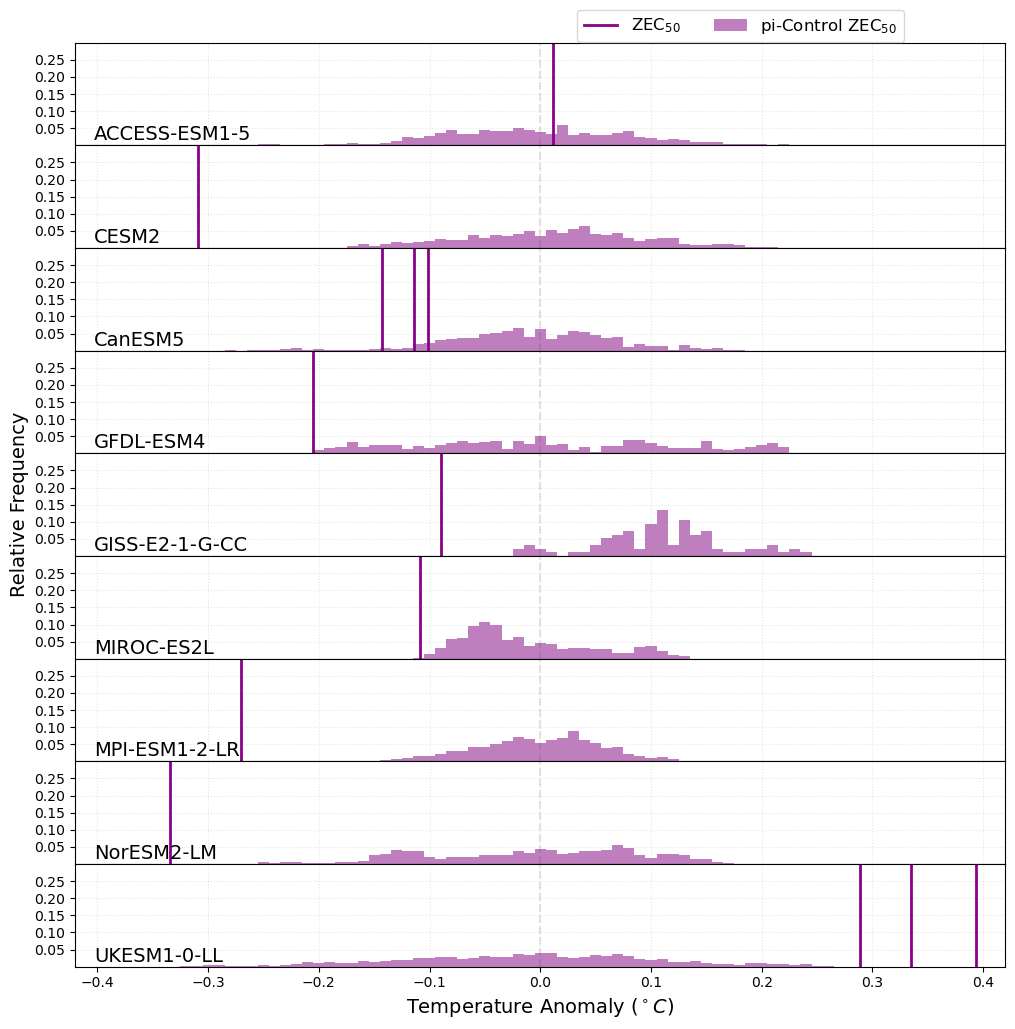

In [57]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(len(esmpi_zec25_xrlist), 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(len(esmpi_zec25_xrlist))]


zecmip_plotting.plot_histogram(esmpi_zec50_xrlist, zec_vals=zec50_xrlist, title_loc='', line_label=r'ZEC$_{50}$', xlabel=LABEl_MAP[variable]['xlabel'], 
                           bar_label=r'pi-Control ZEC$_{50}$', fig=fig, axes=axes,
                 bar_color='purple', line_color='darkmagenta', **repated_kwargs)

leg = axes[0].legend(ncol=4, bbox_to_anchor=[0.9, 1.4], fontsize=12)

key_dim = model
key_dim = model
key_dim = model
key_dim = model


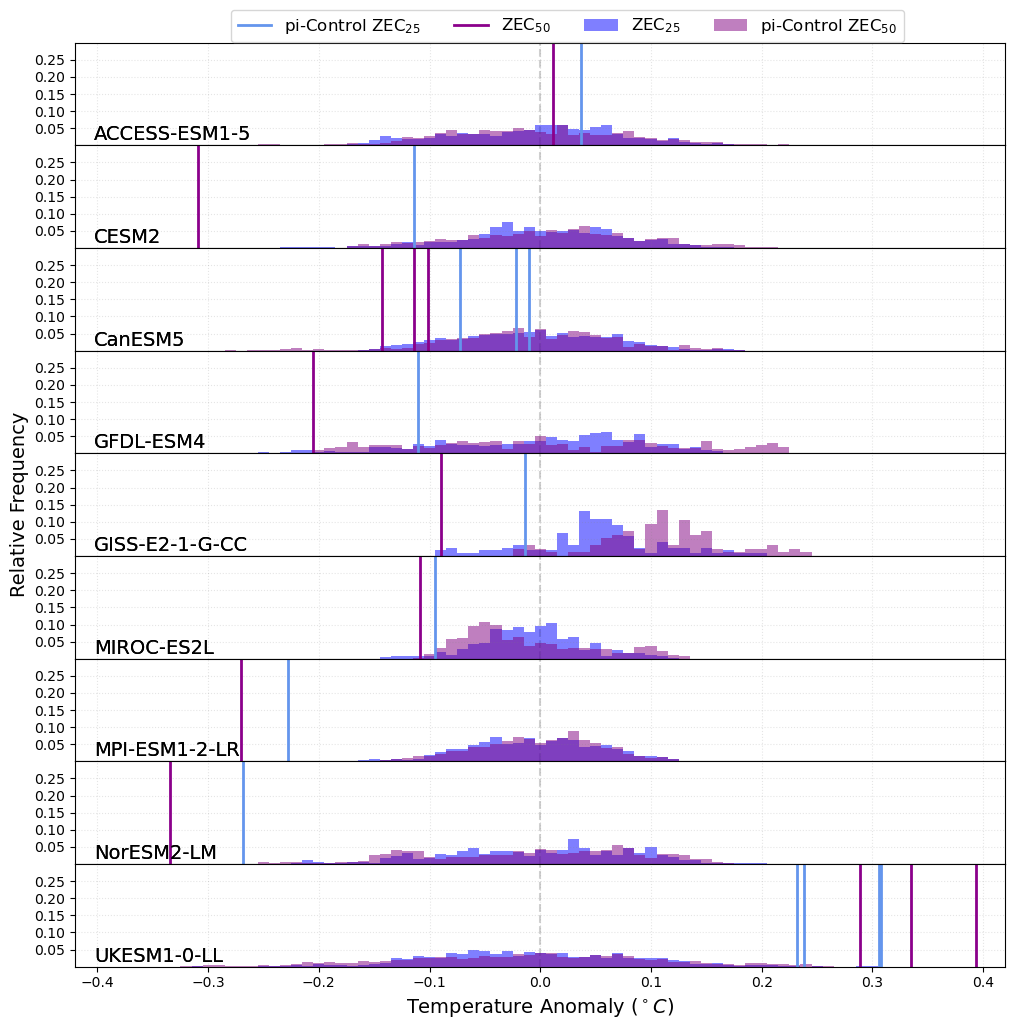

In [58]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(len(esmpi_zec25_xrlist), 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(len(esmpi_zec25_xrlist))]

zecmip_plotting.plot_histogram(esmpi_zec25_xrlist, zec_vals=zec25_xrlist, line_label= r'pi-Control ZEC$_{25}$', bar_label=r'ZEC$_{25}$', fig=fig, axes=axes, 
                           logginglevel='ERROR', line_color='cornflowerblue', title_loc='', **repated_kwargs)
zecmip_plotting.plot_histogram(esmpi_zec50_xrlist, zec_vals=zec50_xrlist, title_loc='', line_label=r'ZEC$_{50}$', xlabel=LABEl_MAP[variable]['xlabel'], 
                           bar_label=r'pi-Control ZEC$_{50}$', fig=fig, axes=axes,
                 bar_color='purple', line_color='darkmagenta', **repated_kwargs)

leg = axes[0].legend(ncol=4, bbox_to_anchor=[0.9, 1.4], fontsize=12)

In [59]:
def return_zec_bounds_df(zec_xrlist, for_bounds_xrlist, threshold=1):
    esmpi_q99_xrlist = for_bounds_xrlist.reduce(np.nanpercentile, q=100-threshold, dim='time').concat('model')
    esmpi_q01_xrlist = for_bounds_xrlist.reduce(np.nanpercentile, q=threshold, dim='time').concat('model')
    
    master_dict = {}
    for model, ds in zec_xrlist:
        # print(f'{model}')
        ensemble_values = ds.ensemble.values
        if ensemble_values.ndim == 0: ensemble_value = [ensemble_values]
        for ensemble in ensemble_values:
            val = ds.sel(ensemble=ensemble).values[0]
            lbound = esmpi_q01_xrlist.to_pandas()[model]
            ubound = esmpi_q99_xrlist.to_pandas()[model]
            status = 'Below' if  val < lbound else 'Above' if val > ubound else 'In'
            # in_bounds = lbound < val < ubound
            # print(f'- {ensemble}: {in_bounds}')
            master_dict[f'{model}_{ensemble}'] = {'lower_bound': lbound, 'ZEC': val, 'upper_bound' : ubound, 'status':status}
    
    zec_bounds_df = pd.DataFrame(master_dict).transpose()
    return zec_bounds_df

In [60]:
variable

'tas'

In [61]:
threshold=1

In [62]:
zec25_bounds_df = return_zec_bounds_df(zec25_xrlist, esmpi_zec25_xrlist, threshold=threshold)
zec50_bounds_df = return_zec_bounds_df(zec50_xrlist, esmpi_zec50_xrlist, threshold=threshold)

In [63]:
zec50_bounds_df

,lower_bound,ZEC,upper_bound,status
ACCESS-ESM1-5_r1i1p1f1,-0.226533,0.011263,0.191839,In
CESM2_r1i1p1f1,-0.158129,-0.309432,0.18865,Below
CanESM5_r1i1p2f1,-0.224659,-0.101714,0.165074,In
CanESM5_r3i1p2f1,-0.224659,-0.142674,0.165074,In
CanESM5_r2i1p2f1,-0.224659,-0.113779,0.165074,In
GFDL-ESM4_r1i1p1f1,-0.187552,-0.205462,0.224115,Below
GISS-E2-1-G-CC_r1i1p1f1,-0.016678,-0.090054,0.238633,Below
MIROC-ES2L_r1i1p1f2,-0.091801,-0.108684,0.122102,Below
MPI-ESM1-2-LR_r1i1p1f1,-0.123346,-0.270157,0.118775,Below
NorESM2-LM_r1i1p1f1,-0.221126,-0.334373,0.15745,Below


In [64]:
zec25_bounds_df

,lower_bound,ZEC,upper_bound,status
ACCESS-ESM1-5_r1i1p1f1,-0.15063,0.036347,0.163695,In
CESM2_r1i1p1f1,-0.184797,-0.113692,0.144865,In
CanESM5_r1i1p2f1,-0.138021,-0.010001,0.161985,In
CanESM5_r3i1p2f1,-0.138021,-0.072108,0.161985,In
CanESM5_r2i1p2f1,-0.138021,-0.022066,0.161985,In
GFDL-ESM4_r1i1p1f1,-0.218125,-0.110839,0.155288,In
GISS-E2-1-G-CC_r1i1p1f1,-0.080118,-0.014214,0.193413,In
MIROC-ES2L_r1i1p1f2,-0.124065,-0.095376,0.111792,In
MPI-ESM1-2-LR_r1i1p1f1,-0.141131,-0.227491,0.119427,Below
NorESM2-LM_r1i1p1f1,-0.203915,-0.26839,0.167632,Below


# TCRE
Note: This does not make sense for any variable other than temperature. Strange concept for anything else really
<br>
Paper on how to calculate TCRE: <br>
https://doi.org/10.1029/2021GL095778

- To gove from GtCO2 to PgC dsivide by 3.67 (ratio of M_CO2 to M_C) 

## Main

In [65]:
CARBON_BUDGET_15_GTCO2 = 380 # The carbon budget to 1.5degC of warming in GtCO2

In [66]:
CURRENT_WARMING = 1.2 # the current warming from CC in degC
REMAINING_WARMING = .3 # We have warmed by 1.1, and the target is 1.5

In [67]:
# TCRE value based upon the remaining carbon budget and the remaining warming to 1.5degC.
# Units are degC/1000PgC.
TCRE_GLOBAL_CARBON = REMAINING_WARMING/(CARBON_BUDGET_15_GTCO2/1000)
TCRE_GLOBAL_CARBON 

0.7894736842105263

In [68]:
MASS_CARBON = 12.011
MASS_OXYGEN = 15.994
MASS_CO2 = MASS_CARBON + 2 * MASS_OXYGEN
RATIO_CO2_C = MASS_CO2/MASS_CARBON
RATIO_CO2_C

3.66322537673799

In [69]:
EMISSIONS_LEVELS_2022_GTCO2 = 40.6 # GtCO2
EMISSIONS_LEVELS_2022_PGCO2 = EMISSIONS_LEVELS_2022_GTCO2
EMISSIONS_LEVELS_2022_GTC = EMISSIONS_LEVELS_2022_GTCO2 * RATIO_CO2_C

In [70]:
RATIO_CO2_C

3.66322537673799

In [71]:
# TCRE is the average at the branch point minues the maean of the pi-Control
tcre_xrlist = branch_point_mean_xrlist - esmpi_smean_xrlist.mean(dim='time') # .isel(time=slice(0, 100))

In [72]:
zec50_dict = zec50_xrlist.to_simple_dict()

In [73]:
rcb_df = pd.DataFrame({
    'model': list(zec50_dict),
    'tcre_degC_per_EgC': list(tcre_xrlist.to_simple_dict().values()),
    'zec50': list(zec50_dict.values())
                 }).set_index('model')

In [74]:
# Calculate the reaming carbon budget - the units for tcre are in EgC (1000PgC) but need to be in PgC - so divide by 1000 
rcb_df['rcb_zec_pgc'] = rcb_df['zec50']/rcb_df['tcre_degC_per_EgC'] * 1000
rcb_df['rcb_zec_gtco2'] = rcb_df['rcb_zec_pgc'] * RATIO_CO2_C

# # Dividing by the emissions in 2022, to get the number of years based upon 2022 levels
rcb_df['zec_rcb_years'] = rcb_df['rcb_zec_gtco2']/EMISSIONS_LEVELS_2022_GTCO2

# # The number of years in the remaining carbon budget based upon the model
# # The remaining warming divided byt the TCRE to give the 1000PgC remaining. Then divide by the emissions
# # per years in 1000PgC units
rcb_df['rcb_GtCO2'] = REMAINING_WARMING/rcb_df['tcre_degC_per_EgC'] * 1000 * RATIO_CO2_C
rcb_df['rcb_years'] = rcb_df['rcb_GtCO2']/EMISSIONS_LEVELS_2022_GTCO2

rcb_df['rcb_percent_change'] = (rcb_df['rcb_zec_gtco2']/rcb_df['rcb_GtCO2']) * 100

In [75]:
# Adding the status in relation to the upper and lower bounds
rcb_df['status'] = zec50_bounds_df['status']

In [76]:
rcb_df.drop('status', axis=1).round(2)

,tcre_degC_per_EgC,zec50,rcb_zec_pgc,rcb_zec_gtco2,zec_rcb_years,rcb_GtCO2,rcb_years,rcb_percent_change
model,,,,,,,,
ACCESS-ESM1-5_r1i1p1f1,1.81,0.01,6.21,22.74,0.56,605.68,14.92,3.75
CESM2_r1i1p1f1,2.01,-0.31,-153.84,-563.54,-13.88,546.36,13.46,-103.14
CanESM5_r1i1p2f1,2.10,-0.10,-48.46,-177.54,-4.37,523.64,12.90,-33.90
CanESM5_r3i1p2f1,2.11,-0.14,-67.59,-247.61,-6.10,520.64,12.82,-47.56
CanESM5_r2i1p2f1,2.24,-0.11,-50.77,-186.00,-4.58,490.41,12.08,-37.93
GFDL-ESM4_r1i1p1f1,1.36,-0.21,-151.62,-555.42,-13.68,810.98,19.97,-68.49
GISS-E2-1-G-CC_r1i1p1f1,1.68,-0.09,-53.57,-196.24,-4.83,653.74,16.10,-30.02
MIROC-ES2L_r1i1p1f2,1.36,-0.11,-79.93,-292.80,-7.21,808.20,19.91,-36.23
MPI-ESM1-2-LR_r1i1p1f1,1.65,-0.27,-163.62,-599.37,-14.76,665.59,16.39,-90.05


In [77]:
rcb_df.round(2)

,tcre_degC_per_EgC,zec50,rcb_zec_pgc,rcb_zec_gtco2,zec_rcb_years,rcb_GtCO2,rcb_years,rcb_percent_change,status
model,,,,,,,,,
ACCESS-ESM1-5_r1i1p1f1,1.81,0.01,6.21,22.74,0.56,605.68,14.92,3.75,In
CESM2_r1i1p1f1,2.01,-0.31,-153.84,-563.54,-13.88,546.36,13.46,-103.14,Below
CanESM5_r1i1p2f1,2.10,-0.10,-48.46,-177.54,-4.37,523.64,12.90,-33.90,In
CanESM5_r3i1p2f1,2.11,-0.14,-67.59,-247.61,-6.10,520.64,12.82,-47.56,In
CanESM5_r2i1p2f1,2.24,-0.11,-50.77,-186.00,-4.58,490.41,12.08,-37.93,In
GFDL-ESM4_r1i1p1f1,1.36,-0.21,-151.62,-555.42,-13.68,810.98,19.97,-68.49,Below
GISS-E2-1-G-CC_r1i1p1f1,1.68,-0.09,-53.57,-196.24,-4.83,653.74,16.10,-30.02,Below
MIROC-ES2L_r1i1p1f2,1.36,-0.11,-79.93,-292.80,-7.21,808.20,19.91,-36.23,Below
MPI-ESM1-2-LR_r1i1p1f1,1.65,-0.27,-163.62,-599.37,-14.76,665.59,16.39,-90.05,Below


In [78]:
rcb_df['rcb_GtCO2'].median(), rcb_df['rcb_GtCO2'].quantile(0.25), rcb_df['rcb_GtCO2'].quantile(0.75)

(534.9999268173772, 453.23016956320726, 662.6247684321877)

In [79]:
rcb_df['rcb_GtCO2'].quantile(0.75) - rcb_df['rcb_GtCO2'].quantile(0.25)

209.39459886898044

In [80]:
variables_of_interest = ['zec50', 'rcb_zec_gtco2', 'zec_rcb_years', 'rcb_percent_change']

In [81]:
rcb_df['rcb_GtCO2'].mean().round(0), rcb_df['rcb_GtCO2'].std()

(580.0, 142.50310339288407)

In [82]:
models_that_cool_df = rcb_df[(rcb_df.zec50 < 0) & (rcb_df.status=='Below')][variables_of_interest]
models_that_cool_df

,zec50,rcb_zec_gtco2,zec_rcb_years,rcb_percent_change
model,,,,
CESM2_r1i1p1f1,-0.309432,-563.541826,-13.880341,-103.144091
GFDL-ESM4_r1i1p1f1,-0.205462,-555.417883,-13.680243,-68.487254
GISS-E2-1-G-CC_r1i1p1f1,-0.090054,-196.240349,-4.833506,-30.018017
MIROC-ES2L_r1i1p1f2,-0.108684,-292.795860,-7.211721,-36.227965
MPI-ESM1-2-LR_r1i1p1f1,-0.270157,-599.374771,-14.762925,-90.052227
NorESM2-LM_r1i1p1f1,-0.334373,-864.948648,-21.304154,-111.457827


In [83]:
# Mean of cooling models
# For this calculation, the mean of the ensembles needs be taken first.
# However, there are not repeated ensembles that cool
models_that_cool_df.mean(axis=0).round(2)

zec50                  -0.22
rcb_zec_gtco2        -512.05
zec_rcb_years         -12.61
rcb_percent_change    -73.23
dtype: float64

In [84]:
513/535 

0.9588785046728971

In [85]:
models_that_cool_df[variables_of_interest].std(axis=0)

zec50                   0.103037
rcb_zec_gtco2         238.538620
zec_rcb_years           5.875335
rcb_percent_change     34.345674
dtype: float64

In [86]:
# Mean of warming models
# For this calculation, the mean of the ensembles needs be taken first.
# However, there are not repeated ensembles that warm
rcb_sig_warm_df = rcb_df[(rcb_df.zec50 > 0) & (rcb_df.status=='Above')][variables_of_interest].mean(axis=0)
rcb_sig_warm_df

zec50                   0.361184
rcb_zec_gtco2         517.893596
zec_rcb_years          12.756000
rcb_percent_change    120.394587
dtype: float64

In [87]:
# Mean of warming models
# For this calculation, the mean of the ensembles needs be taken first.
# However, there are not repeated ensembles that warm
rcb_sig_warm_df = rcb_df[(rcb_df.zec50 > 0) & (rcb_df.status=='Above')][variables_of_interest].std(axis=0)
rcb_sig_warm_df

zec50                  0.061488
rcb_zec_gtco2         92.567712
zec_rcb_years          2.279993
rcb_percent_change    20.496081
dtype: float64

In [88]:
rcb_df

,tcre_degC_per_EgC,zec50,rcb_zec_pgc,rcb_zec_gtco2,zec_rcb_years,rcb_GtCO2,rcb_years,rcb_percent_change,status
model,,,,,,,,,
ACCESS-ESM1-5_r1i1p1f1,1.814446,0.011263,6.207622,22.739919,0.560097,605.676827,14.918148,3.754464,In
CESM2_r1i1p1f1,2.011422,-0.309432,-153.837607,-563.541826,-13.880341,546.363658,13.457233,-103.144091,Below
CanESM5_r1i1p2f1,2.098724,-0.101714,-48.464628,-177.536854,-4.372829,523.636196,12.897443,-33.904618,In
CanESM5_r3i1p2f1,2.110789,-0.142674,-67.592641,-247.607077,-6.098696,520.643154,12.823723,-47.557924,In
CanESM5_r2i1p2f1,2.240899,-0.113779,-50.773752,-185.995698,-4.581175,490.413640,12.079154,-37.926290,In
GFDL-ESM4_r1i1p1f1,1.355111,-0.205462,-151.619905,-555.417883,-13.680243,810.979932,19.974875,-68.487254,Below
GISS-E2-1-G-CC_r1i1p1f1,1.681042,-0.090054,-53.570373,-196.240349,-4.833506,653.741882,16.102017,-30.018017,Below
MIROC-ES2L_r1i1p1f2,1.359765,-0.108684,-79.928432,-292.795860,-7.211721,808.204001,19.906502,-36.227965,Below
MPI-ESM1-2-LR_r1i1p1f1,1.651129,-0.270157,-163.619409,-599.374771,-14.762925,665.585731,16.393737,-90.052227,Below


## Experimental
- Different versions of TCRE to try and match MacDougall
- Scatter of TCRE vs ZEC

Variations of TCRE to Try

Time slices
- 100 years
- Whole pi-Control
- Up to branch

Data modification
- No de-trending
- De-trended pi-onctorl

This gives a total of six scenarios

In [145]:
esmpi_smean_nodrift_01_xrlist =\
            esmpi_smean_xrlist - esmpi_smean_xrlist.apply(stats.trend_fit, method='POLYNOMIAL', order=1)+\
            esmpi_smean_xrlist.mean(dim='time')  

esmpi_smean_nodrift_02_xrlist =\
            esmpi_smean_xrlist - esmpi_smean_xrlist.apply(stats.trend_fit, method='POLYNOMIAL', order=2)+\
            esmpi_smean_xrlist.mean(dim='time')  

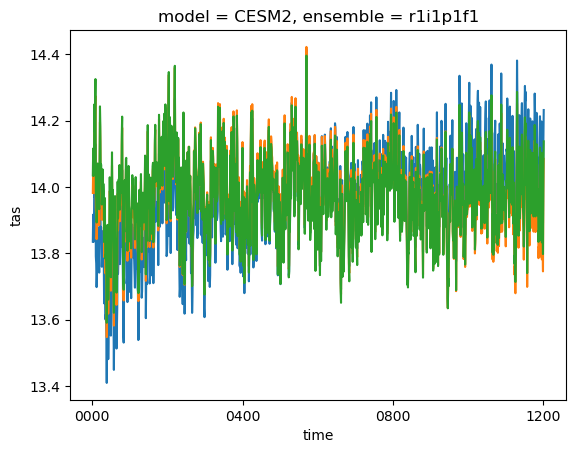

In [146]:
esmpi_smean_xrlist['CESM2'].plot()
esmpi_smean_nodrift_01_xrlist['CESM2'].plot()
esmpi_smean_nodrift_02_xrlist['CESM2'].plot()

In [147]:
pi_mean_df = pd.DataFrame()
pi_mean_df['drift'] = esmpi_smean_xrlist.mean(dim='time').drop('ensemble').to_simple_dict()
pi_mean_df['linear_removal'] = esmpi_smean_nodrift_01_xrlist.mean(dim='time').drop('ensemble').to_simple_dict()
pi_mean_df['quadratic_removal'] = esmpi_smean_nodrift_01_xrlist.mean(dim='time').drop('ensemble').to_simple_dict()


pi_mean_df['diff_lin'] = pi_mean_df['drift'] - pi_mean_df['linear_removal']
pi_mean_df['diff_quad'] = pi_mean_df['drift'] - pi_mean_df['quadratic_removal']

pi_mean_df.round(3)

,drift,linear_removal,quadratic_removal,diff_lin,diff_quad
ACCESS-ESM1-5,14.494,14.494,14.494,0.0,0.0
CESM2,13.972,13.972,13.972,0.0,0.0
CanESM5,13.417,13.417,13.417,0.0,0.0
GFDL-ESM4,13.414,13.414,13.414,-0.0,-0.0
GISS-E2-1-G-CC,13.845,13.845,13.845,0.0,0.0
MIROC-ES2L,14.984,14.984,14.984,-0.0,-0.0
MPI-ESM1-2-LR,13.533,13.533,13.533,-0.0,-0.0
NorESM2-LM,14.464,14.464,14.464,-0.0,-0.0
UKESM1-0-LL,13.331,13.331,13.331,0.0,0.0


In [148]:
# Calcultae the mean up to the branch point
to_branch_list = []
for model in a1_xrlist.refkeys:
    ds_a1_start = a1_xrlist[model].time.dt.year.values[0]
    request_pi_length = np.argwhere(pct_smean_xrlist[model].time.dt.year.values == ds_a1_start)[0][0]
    esmpi_smean_to_branch = esmpi_smean_xrlist[model].isel(time=slice(0, request_pi_length))#.mean(dim='time')
    to_branch_list.append(esmpi_smean_to_branch)
esmpi_smean_branch_subset_xrlist = listXarray(to_branch_list, key_dim='model')

In [149]:
esmpi_smean_branch_subset_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'model': 1, 'time': 67})
CESM2         ({'model': 1, 'time': 67})
CanESM5       ({'model': 1, 'time': 61})
GFDL-ESM4     ({'model': 1, 'time': 63})
GISS-E2-1-G-CC({'model': 1, 'time': 70})
MIROC-ES2L    ({'model': 1, 'time': 63})
MPI-ESM1-2-LR ({'model': 1, 'time': 65})
NorESM2-LM    ({'model': 1, 'time': 66})
UKESM1-0-LL   ({'model': 1, 'time': 66})

In [150]:
pct_smean_xrlist[0].isel(time=slice(60, 80))

<xarray.DataArray 'tas' (ensemble: 1, model: 1, time: 20)>
dask.array<chunksize=(1, 1, 20), meta=np.ndarray>
Coordinates:
  * model     (model) <U13 'ACCESS-ESM1-5'
  * ensemble  (ensemble) <U8 'r1i1p1f1'
  * time      (time) object 0161-12-31 00:00:00 ... 0180-12-31 00:00:00

In [152]:
tcre_subset_branch_point_xrlist = branch_point_mean_xrlist - esmpi_smean_branch_subset_xrlist.isel(time=slice(0, 80)).mean(dim='time')

In [153]:
tcre_100yr_xrlist = branch_point_mean_xrlist - esmpi_smean_xrlist.isel(time=slice(0, 100)).mean(dim='time')

In [154]:
pct_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5 ({'ensemble': 1, 'model': 1, 'time': 150, 'lat': 145, 'lon': 192})
CESM2         ({'ensemble': 1, 'model': 1, 'time': 150, 'lat': 192, 'lon': 288})
CanESM5       ({'ensemble': 3, 'model': 1, 'time': 151, 'lat': 64, 'lon': 128})
GFDL-ESM4     ({'ensemble': 1, 'model': 1, 'time': 150, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC({'ensemble': 1, 'model': 1, 'time': 151, 'lat': 90, 'lon': 144})
MIROC-ES2L    ({'ensemble': 1, 'model': 1, 'time': 150, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR ({'ensemble': 1, 'model': 1, 'time': 165, 'lat': 96, 'lon': 192})
NorESM2-LM    ({'ensemble': 1, 'model': 1, 'time': 150, 'lat': 96, 'lon': 144})
UKESM1-0-LL   ({'ensemble': 4, 'model': 1, 'time': 150, 'lat': 144, 'lon': 192})

In [155]:
tcre_df = pd.DataFrame()
tcre_df['full_pi'] =  tcre_xrlist.to_simple_dict()
tcre_df['100_year'] = tcre_100yr_xrlist.to_simple_dict()
tcre_df['a1_branch_subset'] = tcre_subset_branch_point_xrlist.to_simple_dict()

In [156]:
tcre_macdougall = {
    'ACCESS-ESM1-5_r1i1p1f1': 1.9, 
    'CESM2_r1i1p1f1': 2, 
    'GFDL-ESM4_r1i1p1f1': 1.2, 
    'MIROC-ES2L_r1i1p1f2': 1.3, 
    'MPI-ESM1-2-LR_r1i1p1f1': 1.6, 
    'NorESM2-LM_r1i1p1f1':1.5 }

In [157]:
tcre_df['MacDougall'] = tcre_macdougall
tcre_df['diff_full'] = tcre_df['MacDougall'] - tcre_df['full_pi'] 
tcre_df['diff_100year'] = tcre_df['MacDougall'] - tcre_df['100_year'] 
tcre_df['diff_a1_branch_subset'] = tcre_df['MacDougall'] - tcre_df['a1_branch_subset'] 

# rcb_df_mac_comp  = rcb_df_mac_comp.dropna()

In [98]:
# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(3 * len(rcb_df_mac_comp.columns), 20))

# # Hide the axes
# ax.axis('off')

# # Create a table and add it to the axis
# table = ax.table(cellText=rcb_df_mac_comp.values.round(2),
#                  colLabels=rcb_df_mac_comp.columns,
#                  rowLabels=rcb_df_mac_comp.index,
#                  cellLoc='center',
#                  loc='upper center')
# # Format the table
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.scale(1, 1.2)  # Scale the table to fit the cell contents

# # Show the table
# plt.tight_layout()

In [ ]:
shape_list = ['o', 'x', 'v', 's']

In [ ]:
colors = [
    'b',  # Blue
    'g',  # Green
    'r',  # Red
    'c',  # Cyan
    'm',  # Magenta
    'y',  # Yellow
    'k',  # Black
    '#FFA07A',  # Light Salmon
    '#7B68EE',  # Medium Slate Blue
    '#00BFFF',  # Deep Sky Blue
    '#FFD700',  # Gold
    '#8A2BE2',  # Blue Violet
    '#3CB371',  # Medium Sea Green
    '#BA55D3',  # Medium Orchid
    '#FF6347',  # Tomato
    '#87CEEB',  # Sky Blue
    '#9966CC'   # Amethyst
]

In [ ]:
# Each model, with the model appearing the number of times the model occurs. This is used
# to determine if a model has an ensemble
all_models_w_repeats = models_already_added = ['-'.join(key.split('_')[:-1]) for key in rcb_df.index.values]

In [ ]:
# Creating a dictionary that has a unqiue shape and the same color for each ensemble, and a different color
# for each model
shape_color_dict = {}

color_num = 0 
shape_num = 0

for index, row in rcb_df.iterrows():
    # print(f'{index} - ', end='')
    current_model = '-'.join(index.split('_')[:-1])
    models_already_added = ['-'.join(key.split('_')[:-1]) for key in list(shape_color_dict)]
    if current_model not in models_already_added and all_models_w_repeats.count(current_model) > 1:
        # If the model appears multiple times but, has not bee added
        # print('Model first isntance')
        color_num += 1
        shape_num = 0
    elif current_model in models_already_added and all_models_w_repeats.count(current_model) > 1:
        # If the model appears multiple times and has not been added
        # print('Model already used - updating shape')
        shape_num += 1 # If the model is already there, then we want to use a new shape
        shape = shape_list[shape_num]
    else:
        # Model only appears once
        # print('Unique model')
        color_num += 1
        shape_num = 0
        shape = shape_list[shape_num]
        
    shape_color_dict[index] = {'shape': shape, 'color':colors[color_num]}      

shape_color_dict

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
for index, row in rcb_df.iterrows():
   
    ax.scatter(row['tcre_70yr_degC_per_EgC'], row['zec50'], label=index,
               marker=shape_color_dict[index]['shape'], c=shape_color_dict[index]['color'])

ax.set_xlabel('TCRE')
ax.set_ylabel('zec50')
ax.set_title('Scatter Plot of Data from rcb_df')
ax.grid(True, linestyle='--', color='grey', alpha=0.2)
# Add a prominent gridline at x=0 and y=0
ax.axhline(0, color='k', linewidth=1)  # Horizontal line at y=0
ax.axvline(0, color='k', linewidth=1)  # Vertical line at x=0

ax.legend(bbox_to_anchor=(1.01, 1))

# Saving Data

In [ ]:
SAVE = 0

In [ ]:
variable

In [ ]:
REMOVE = False

In [ ]:
SAVE_DIR = '/g/data/w40/ab2313/PhD/zecmip/xrlist'

In [ ]:
if SAVE:
    fname = f'{SAVE_DIR}/{variable}_zec50_xrlist.csv'
    if os.path.exists(fname):
        if REMOVE: 
            print('Removing file')
            os.remove(fname)
    else:
        print(f'Saving {fname=}')
        zec50_xrlist.to_pandas().to_csv(fname)

In [ ]:
if SAVE:
    fname = f'{SAVE_DIR}/{variable}_zec25_xrlist.csv'
    if os.path.exists(fname):
        if REMOVE:
            print('Removing file')
            os.remove(fname)
    else:
        print(f'Saving {fname=}')
        zec25_xrlist.to_pandas().to_csv(fname)

In [ ]:
if SAVE:
    esmpi_zec50_xrlist.to_netcdf(f'/g/data/w40/ab2313/PhD/zecmip/xrlist/{variable}_esmpi_zec50_xrlist', 
                                 logginglevel='DEBUG', force=True)

In [ ]:
if SAVE:
    esmpi_zec25_xrlist.to_netcdf(f'/g/data/w40/ab2313/PhD/zecmip/xrlist/{variable}_esmpi_zec25_xrlist', logginglevel='DEBUG',
                                force=True)

# Detecting Changes in Variability

In [ ]:
esmpi_smean_xrlist = esmpi_smean_xrlist.compute()

In [ ]:
esmpi_smean_anom_xrlist = esmpi_smean_xrlist - esmpi_smean_xrlist.mean(dim='time')

In [ ]:
a1_smean_anom_trendfit_xrlist = a1_smean_anom_xrlist.apply(stats.trend_fit, method='polynomial', order=4)

a1_smean_anom_detrend_xrlist = a1_smean_anom_xrlist - a1_smean_anom_trendfit_xrlist

In [ ]:
stats_test_stor = {}
for model in esmpi_smean_xrlist.refkeys:
    # print(model)
    #pi_vals = esmpi_smean_xrlist[model].squeeze().dropna(dim='time').values
    #pi_vals_anom = pi_vals - np.nanmean(pi_vals)
    pi_vals_anom = esmpi_smean_anom_xrlist[model].dropna(dim='time').squeeze().values
    a1_ds = a1_smean_anom_xrlist[model]
    for ensemble in a1_ds.ensemble.values:
        # print(f' - {ensemble=}')

        a1_vals_detrend = a1_smean_anom_detrend_xrlist[model].sel(ensemble=ensemble).dropna(dim='time').squeeze().values
        ks_out = ks_2samp(pi_vals_anom, a1_vals_detrend).pvalue
        ttest_out = ttest_ind(pi_vals_anom, a1_vals_detrend).pvalue
        levene_out = levene(pi_vals_anom, a1_vals_detrend).pvalue
        bartlett_out = bartlett(pi_vals_anom, a1_vals_detrend).pvalue
        kruskal_out = kruskal(pi_vals_anom, a1_vals_detrend).pvalue
        ks_pi_not_normal = scipy.stats.kstest(pi_vals_anom, 'norm').pvalue
        ks_a1_not_normal = scipy.stats.kstest(pi_vals_anom, 'norm').pvalue
        stats_test_stor[f'{model}_{ensemble}'] = {
            #'ttest':ttest_out, 'kstest':ks_out, 
            'bartlett':bartlett_out,'levene':levene_out, 'kruskal':kruskal_out,
            'is_pi_normal_(ks)': ks_pi_not_normal, 'is_a1_normal_(ks)':ks_a1_not_normal}
    # print('\n')

In [ ]:
stats_test_df = pd.DataFrame(stats_test_stor).round(2).transpose()
stats_test_df.head()

In [ ]:
@np.vectorize
def cell_color(val, threshold=0.05): return 'red' if val < 0.05 else 'white'

In [ ]:
def plot_distributions(pi_data, a1_data, ax):

    
    # Define bins for the histogram
    bins = np.arange(-0.5, 0.4, 0.025)

    
    # Fit a normal distribution to the data
    mean1, std1 = scipy.stats.norm.fit(pi_data)
    mean2, std2 = scipy.stats.norm.fit(a1_data)
    sigma_ratio =std1/std2

    # Create the x values for the normal distribution plot
    x = np.linspace(-0.5, 0.4, 100)
    

    ax.hist(pi_data, bins=bins, alpha=0.5, label='pi-Control', density=True)
    ax.plot(x, scipy.stats.norm.pdf(x, mean1, std1), label='pi-Control', color='blue')
    ax.hist(a1_data, bins=bins, alpha=0.5, label='1000-PgC branch', density=True)
    ax.plot(x, scipy.stats.norm.pdf(x, mean2, std2), label='1000-PgC branch', color='orange')
    
    # Add labels, legend, and title
    ax.set_xlabel('Temperature Anomaly (K)')
    ax.set_ylabel('Frequency')
    ax.set_title(round(sigma_ratio, 2))


In [ ]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(4, 4, hspace=0.4)
axes = [fig.add_subplot(gs[i]) for i in range(14)]
num = 0
for model in esmpi_smean_anom_xrlist.refkeys:
    # Data for the histogram (replace this with your actual data)
    pi_data = esmpi_smean_anom_xrlist[model].dropna(dim='time').squeeze()
    a1_data = a1_smean_anom_detrend_xrlist[model]
    for ensemble in a1_data.ensemble.values:
        a1_data_ens = a1_data.sel(ensemble=ensemble).dropna(dim='time').squeeze()
        plot_distributions(pi_data, a1_data_ens, axes[num])
        sigma_ratio = axes[num].get_title()
        title = f'{model} - {ensemble}' if len(a1_data.ensemble.values) > 1 else model
        axes[num].set_title(title + r' ($\sigma_{pi}/\sigma_{A1}$'+f' = {sigma_ratio})')
        num += 1


handles, labels = axes[1].get_legend_handles_labels()
placeholder_handles = [axes[1].plot([], marker="", ls="")[0]] * 2
handles = placeholder_handles + handles
labels = ["Distributions:", "Normal Distribution Fitting:"] + labels

# Create the legend with two columns and titles for each column
legend = axes[1].legend(handles, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.6, 1.6), fontsize='large')


In [ ]:
stats_test_df[['kruskal']]

In [ ]:
df_for_table = stats_test_df[['kruskal']]

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(3 * len(df_for_table.columns), 3))

# Hide the axes
ax.axis('off')

# Create a table and add it to the axis
table = ax.table(cellText=df_for_table.values.round(2),
                 colLabels=df_for_table.columns,
                 rowLabels=df_for_table.index,
                 cellLoc='center',
                 loc='upper center',
                 cellColours=cell_color(df_for_table.values))

# Format the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)  # Scale the table to fit the cell contents

# Show the table
plt.tight_layout()

# Local Analysis

In [ ]:
# Calculte the anomaly at the branch point
branch_point_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(pct_xrlist[model], a1_xrlist[model]) for model in pct_xrlist.refkeys]).set_refkeys('model')

In [ ]:
a1_anom_xrlist = (a1_xrlist - branch_point_xrlist).compute()

In [ ]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_local_xrlist = a1_anom_xrlist.isel(time=slice(15, 35)).mean(dim='time').sort_by_refkey()
zec50_local_xrlist = a1_anom_xrlist.isel(time=slice(40, 60)).mean(dim='time').sort_by_refkey()

In [ ]:
zec90_local_xrlist = a1_anom_xrlist.isel(time=slice(80, 100)).mean(dim='time').sort_by_refkey()

In [ ]:
reload(sn_plotting)

In [ ]:
# !!! Warning -  this errors a few times before it runs. It's to do with the type(listXarray).
# Not sure why this is occuring

models = zec50_local_xrlist.refkeys
nrows = 4; ncols = 3
fig = plt.figure(figsize=(6*ncols, 4*ncols))
gs = gridspec.GridSpec(nrows, ncols, height_ratios = [1]*3 + [0.1], hspace=0, wspace=0.1)
cax = plt.subplot(gs[3, :])

zec_kwargs = dict(levels=np.arange(-3, 3.2, .2), extend='both', cmap=LABEl_MAP[variable].get('cmap', 'RdBu_r'), font_scale=0.7)

fig, gs, axes1, cbar = sn_plotting.map_plot_all_for_coords_3(
    zec50_local_xrlist.isel(ensemble=0), dim='model', fig=fig, gs=gs, cax=cax, add_colorbar=True,
    logginglevel='INFO', **zec_kwargs)

In [ ]:
models = zec25_local_xrlist.refkeys
nrows = 4; ncols = 3
fig = plt.figure(figsize=(6*ncols, 4*ncols))
gs = gridspec.GridSpec(nrows, ncols, height_ratios = [1]*3 + [0.1], hspace=0, wspace=0.1)
cax = plt.subplot(gs[3, :])

zec_kwargs = dict(extend='both', cmap=LABEl_MAP[variable].get('cmap', 'RdBu_r'), font_scale=0.7)

fig, gs, axes1, cbar = sn_plotting.map_plot_all_for_coords_3(
    zec25_local_xrlist.isel(ensemble=0),levels=np.arange(-3, 3.2, .2), fig=fig, gs=gs, cax=cax, add_colorbar=True,
    logginglevel='ERROR', **zec_kwargs)

In [ ]:
# ZEC25 starts at year 15, base period finishes year 10 => 5 years
esmpi_zec25_local_xrlist = esmpi_xrlist.apply(calculate_rolling_period_diff, 5)

# ZEC50 starts at year 40, base period finishes year 10 => 30 years
esmpi_zec50_local_xrlist = esmpi_xrlist.apply(calculate_rolling_period_diff, 30)

In [ ]:
# ZEC90 starts at year 80, base period finishes year 10 => 70 years
esmpi_zec90_local_xrlist = esmpi_xrlist.apply(calculate_rolling_period_diff, 70)

In [ ]:
def create_range_analysis(esmpi_xrlist: xr.Dataset, zec_xrlist: xr.Dataset) -> xr.Dataset:
    """
    Create a range analysis of temperature anomalies compared to pre-industrial (PI) levels.

    Parameters:
        esmpi_xrlist (xr.Dataset): Dataset containing temperature anomalies for different models (ensemble members).
        zec_xrlist (xr.Dataset): Dataset containing ZEC50 values (previously calculated) for each model.

    Returns:
        xr.Dataset: Dataset containing information about whether the temperature anomalies are outside the 1st and 99th percentiles 
                    compared to pre-industrial levels for each model and time step.
    """
    # Calculate the upper and lower bounds for each model using the 1st and 99th percentiles
    upper_bound_xrlist = esmpi_xrlist.apply(xe.percentile, dim='time', q=99).set_refkeys('model')
    lower_bound_xrlist = esmpi_xrlist.apply(xe.percentile, dim='time', q=1).set_refkeys('model')
    
    # Find the time steps where temperature anomalies are warmer than the upper bound (99th percentile)
    warmer_than_pi_xrlist = zec_xrlist.greater_than(upper_bound_xrlist, 1, 0)
    
    # Find the time steps where temperature anomalies are cooler than the lower bound (1st percentile)
    cooler_than_pi_xrlist = zec_xrlist.less_than(lower_bound_xrlist, -1, 0) 
    
    # Combine the two results to get a final analysis of temperature anomalies compared to pre-industrial levels
    pi_comparison_xrlist = warmer_than_pi_xrlist + cooler_than_pi_xrlist
    
    # Compute the results to get a concrete Dataset
    pi_comparison_xrlist = pi_comparison_xrlist.compute()
    
    return pi_comparison_xrlist


In [ ]:
pi_comparison_zec25_xrlist = create_range_analysis(esmpi_zec25_local_xrlist, zec25_local_xrlist)

In [ ]:
pi_comparison_zec50_xrlist = create_range_analysis(esmpi_zec25_local_xrlist, zec50_local_xrlist)

In [ ]:
pi_comparison_zec90_xrlist = create_range_analysis(esmpi_zec90_local_xrlist, zec90_local_xrlist)

## Plotting

In [ ]:
models = pi_comparison_zec25_xrlist.refkeys
models

In [ ]:
zec50_local_regrid_xrlist = zec50_local_xrlist.isel(ensemble=0).regrid('MPI-ESM1-2-LR', 'bilinear')
zec50_local_regrid_ds = xr.concat(zec50_local_regrid_xrlist.to_list(), dim='model')

In [ ]:
zec50_local_regrid_ds.mean(dim='model').plot()

In [ ]:
# Regriddging
pi_comparison_regrid_zec25_xrlist = pi_comparison_zec25_xrlist.regrid('MPI-ESM1-2-LR', 'nearest_s2d')
pi_comparison_regrid_zec25_xrlist = pi_comparison_regrid_zec25_xrlist.isel(ensemble=0)
pi_comparison_regrid_zec25_ds = xr.concat(pi_comparison_regrid_zec25_xrlist.to_list(), dim='model')

pi_comparison_regrid_zec50_xrlist = pi_comparison_zec50_xrlist.regrid('MPI-ESM1-2-LR', 'nearest_s2d')
pi_comparison_regrid_zec50_xrlist = pi_comparison_regrid_zec50_xrlist.isel(ensemble=0)
pi_comparison_regrid_zec50_ds = xr.concat(pi_comparison_regrid_zec50_xrlist.to_list(), dim='model')

In [ ]:
pi_comparison_regrid_zec90_xrlist = pi_comparison_zec90_xrlist.regrid('MPI-ESM1-2-LR', 'nearest_s2d')
pi_comparison_regrid_zec90_xrlist = pi_comparison_regrid_zec90_xrlist.isel(ensemble=0)
pi_comparison_regrid_zec90_ds = xr.concat(pi_comparison_regrid_zec90_xrlist.to_list(), dim='model')

In [ ]:
levels = [-1, 0, 1]

In [ ]:
number_models = len(models); number_models

In [ ]:
discrete_cmap = pf.create_discrete_cmap('BrBG', levels=levels)

In [ ]:
cmap_red = plt.cm.get_cmap('Greens', number_models+2) # YlOrRd
cmap_blue = plt.cm.get_cmap('YlOrBr', number_models+2) # YlGnBu

In [ ]:
num_plot_levels = np.arange(0,number_models+2)
num_plot_levels

In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(4, 2, wspace=.1, hspace=.1, height_ratios=[1, 1, 1, 0.1])

axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson()) for i in range(0, 6)]
[ax.coastlines() for ax in axes]

total_number_kwargs = dict(levels=num_plot_levels, transform=ccrs.PlateCarree(), add_colorbar=False) #vmax=9, vmin=0

### Cool
# ZEC25
cool_plot = pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec25_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[0], cmap=cmap_blue,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[2], cmap=cmap_blue,**total_number_kwargs)
# ZEC90
pi_comparison_regrid_zec90_ds.where(pi_comparison_regrid_zec90_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[4], cmap=cmap_blue,**total_number_kwargs)

plotting_functions.create_colorbar(cool_plot, cax=plt.subplot(gs[3, 0]), levels=num_plot_levels, cbar_title='Number of Models Less than pi-Control Range', 
                                  tick_offset='center')

### Warm
# ZEC25
warm_plot = pi_comparison_regrid_zec25_ds.where(pi_comparison_regrid_zec25_ds > 0).sum(dim='model').plot(ax=axes[1], cmap=cmap_red,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds > 0).sum(dim='model').plot(ax=axes[3], cmap=cmap_red,**total_number_kwargs)
# ZEC90
pi_comparison_regrid_zec90_ds.where(pi_comparison_regrid_zec90_ds > 0).sum(dim='model').plot(ax=axes[5], cmap=cmap_red,**total_number_kwargs)


cbar = plotting_functions.create_colorbar(warm_plot, cax=plt.subplot(gs[3, 1]), levels=num_plot_levels, cbar_title='Number of Models Greater than pi-Control Range', 
                                  tick_offset='center', logginglevel='ERROR')


[ax.set_title('') for ax in axes]
axes[0].annotate('ZEC25', xy=(-0.16, 0.5), xycoords='axes fraction', fontsize=18)
axes[2].annotate('ZEC50', xy=(-0.16, 0.5), xycoords='axes fraction', fontsize=18)
axes[4].annotate('ZEC90', xy=(-0.16, 0.5), xycoords='axes fraction', fontsize=18)

In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 2, wspace=.1, hspace=.1, height_ratios=[1, 1, 0.1])

axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson()) for i in range(0, 4)]
[ax.coastlines() for ax in axes]

total_number_kwargs = dict(levels=num_plot_levels, transform=ccrs.PlateCarree(), add_colorbar=False) #vmax=9, vmin=0

### Cool
# ZEC25
cool_plot = pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec25_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[0], cmap=cmap_blue,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[2], cmap=cmap_blue,**total_number_kwargs)
plotting_functions.create_colorbar(cool_plot, cax=plt.subplot(gs[2, 0]), levels=num_plot_levels, cbar_title='Number of Models Cooler than pi-Control', 
                                  tick_offset='center')

### Warm
# ZEC25
warm_plot = pi_comparison_regrid_zec25_ds.where(pi_comparison_regrid_zec25_ds > 0).sum(dim='model').plot(ax=axes[1], cmap=cmap_red,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds > 0).sum(dim='model').plot(ax=axes[3], cmap=cmap_red,**total_number_kwargs)

cbar = plotting_functions.create_colorbar(warm_plot, cax=plt.subplot(gs[2, 1]), levels=num_plot_levels, cbar_title='Number of Models Warmer than pi-Control', 
                                  tick_offset='center', logginglevel='ERROR')


# Adding in the figures labels
for num, ax in enumerate(axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', y=0.95)
[ax.set_title('') for ax in axes]
axes[0].annotate('ZEC25', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=18)
axes[2].annotate('ZEC50', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=18)

In [ ]:
pi_comparison_zec25_xrlist = pi_comparison_zec25_xrlist.sort_by_refkey()

In [ ]:
models = pi_comparison_zec25_xrlist.refkeys
models

In [ ]:
levels = [-1, 0, 1]
discrete_cmap = pf.create_discrete_cmap('PuOr', levels=levels)

In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
above_below_cmap = ListedColormap( [cmap_blue(np.arange(10))[4], 'white', cmap_red(np.arange(10))[3]])
above_below_cmap

In [ ]:
ds = pi_comparison_zec25_xrlist['CanESM5']
ensembles = ds.ensemble.values

fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(2, len(ensembles), height_ratios=[1] + [0.1], hspace=0)
cax = plt.subplot(gs[1, :])
axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson(central_longitude=180)) for i in range(len(ensembles))]


for num, (ax, ensemble) in enumerate(zip(axes, ensembles)):
    c = ds.sel(ensemble=ensemble).plot(
        ax=ax, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), cmap=above_below_cmap, add_colorbar=False, 
        rasterized=True)
    ax.set_title(f'{ensemble}')
    ax.coastlines()
    
    # plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.6)
    
cbar = plotting_functions.create_colorbar(c, cax, levels=levels)
cbar.set_ticks([-0.75, 0, 0.75])
cbar.ax.set_xticklabels(['Coooler than\npi-Control Range', 'Within\npi-Control Range', 'Warmer that\npi-Control Range']);

In [ ]:
ds = pi_comparison_zec25_xrlist['UKESM1-0-LL']
ensembles = ds.ensemble.values

fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(2, len(ensembles), height_ratios=[1] + [0.1], hspace=0)
cax = plt.subplot(gs[1, :])
axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson(central_longitude=180)) for i in range(len(ensembles))]


for num, (ax, ensemble) in enumerate(zip(axes, ensembles)):
    c = ds.sel(ensemble=ensemble).plot(
        ax=ax, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), cmap=above_below_cmap, add_colorbar=False, 
        rasterized=True)
    ax.set_title(f'{ensemble}')
    ax.coastlines()
    # plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.6)
    
cbar = plotting_functions.create_colorbar(c, cax, levels=levels)
cbar.set_ticks([-0.75, 0, 0.75])
cbar.ax.set_xticklabels(['Coooler than\npi-Control Range', 'Within\npi-Control Range', 'Warmer that\npi-Control Range']);

In [ ]:
fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(4, 3, height_ratios=[1] * 3 + [0.1], hspace=0)
cax = plt.subplot(gs[3, :])
axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson(central_longitude=180)) for i in range(9)]

for num, (ax, model) in enumerate(zip(axes, models)):
    c = pi_comparison_zec50_xrlist[model].mean(dim='ensemble').plot(
        ax=ax, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), cmap=above_below_cmap, add_colorbar=False, 
        rasterized=True)
    ax.set_title(f'{model}')
    ax.coastlines()
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.6)
    
cbar = plotting_functions.create_colorbar(c, cax, levels=levels)
cbar.set_ticks([-0.75, 0, 0.75])
cbar.ax.set_xticklabels(['Coooler than\npi-Control Range', 'Within\npi-Control Range', 'Warmer that\npi-Control Range']);

# Global Average Time Series

In [183]:
esmpi_smean_ds = esmpi_smean_xrlist.apply(utils.reset_time_to_0_start).concat('model').sortby('model').chunk('auto')

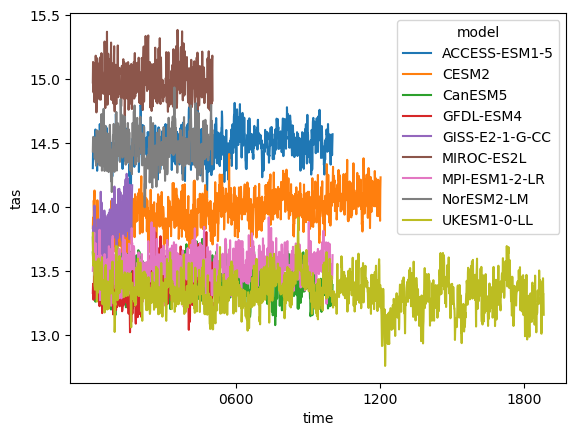

In [184]:
esmpi_smean_ds.plot(hue='model');

In [185]:
time = esmpi_smean_ds.time.values
time_0_start = utils.convert_to_0_start_cftime(esmpi_smean_ds.time.values)

# Assuming your time_0_start is a list or array of cftime objects
min_year = min([date.year for date in time_0_start])
max_year = max([date.year for date in time_0_start])


# Create a list of years from min_year to max_year at 25-year intervals
years_25 = list(range(min_year, max_year+250, 250))
years_25 = np.array(years_25)-1
years_25

array([   0,  250,  500,  750, 1000, 1250, 1500, 1750, 2000])

In [186]:
models = esmpi_smean_ds.model.values

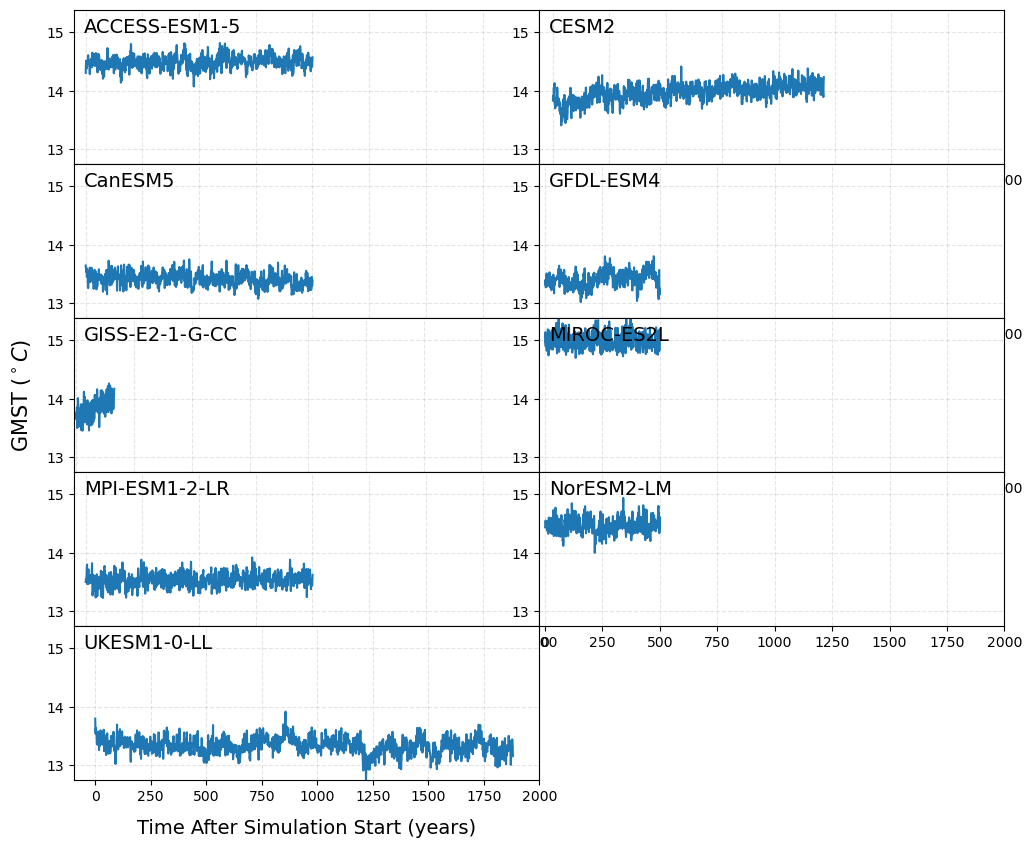

In [187]:
# Convert the years to cftime objects (you might need to adjust the cftime object type based on your data)
ticks = [cftime.DatetimeNoLeap(year, 1, 1) for year in years_25]

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(esmpi_smean_ds.model.values):
    ds_vals = esmpi_smean_ds.sel(model=model).squeeze().values
    ax = axes[num]
    ax.plot(time_0_start[:len(ds_vals)], ds_vals)

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    
    # Manually set x-axis ticks and labels
    ax.set_xticks(ticks)
    ax.set_xticklabels(years_25)        
    ax.set_ylim(esmpi_smean_ds.min().values, esmpi_smean_ds.max().values)
    ax.grid(True, linestyle='--', color='gray', alpha=0.2)
            
    if num ==4: ax.set_ylabel('GMST '+r'($^\circ C$)', fontsize=15, rotation=90, labelpad=10)

ax.set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25);

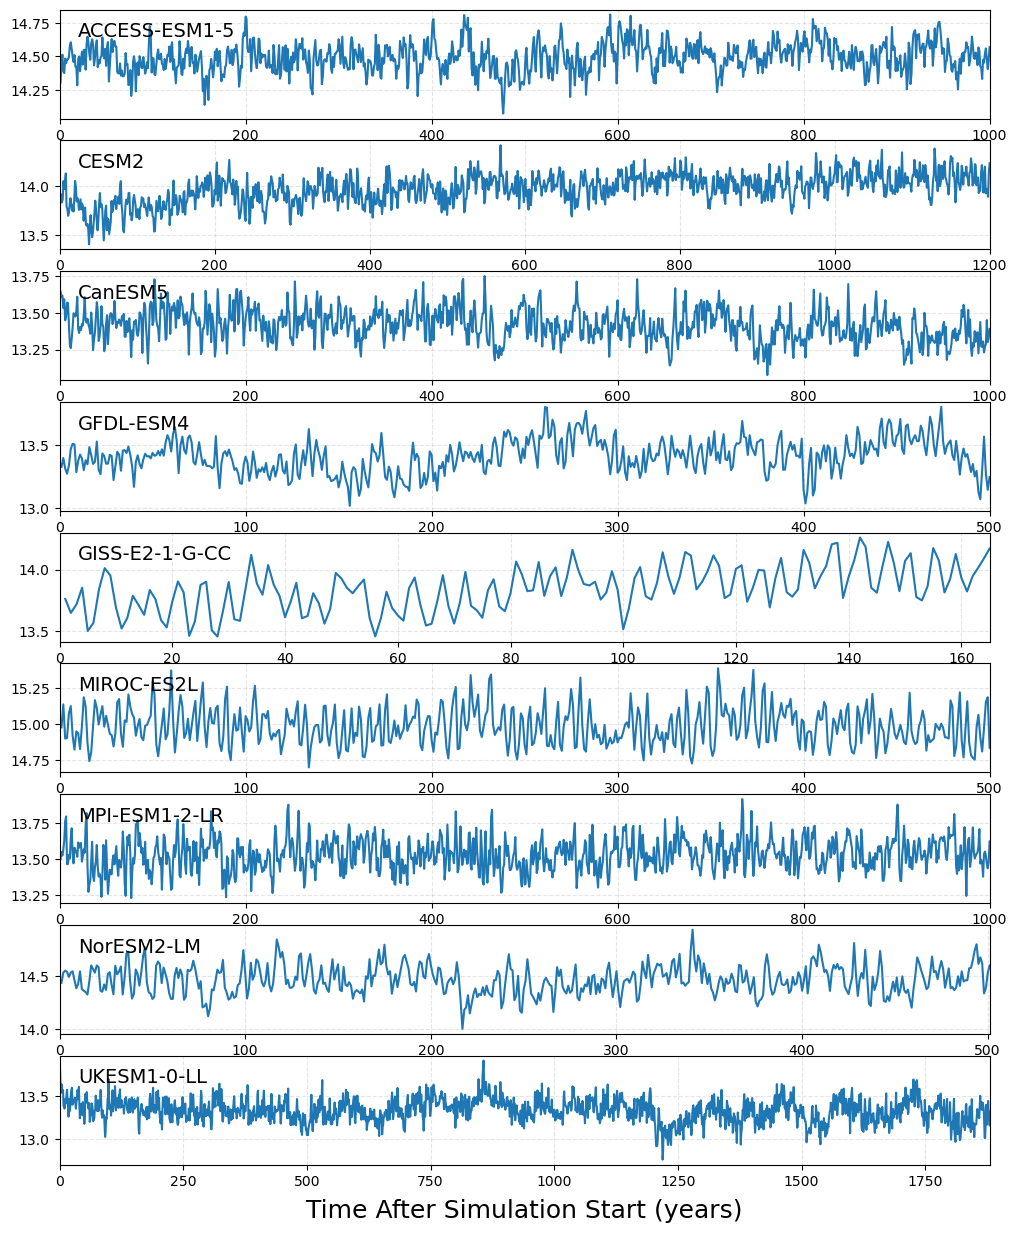

In [188]:
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(9, 1, hspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(esmpi_smean_ds.model.values):
    ds = esmpi_smean_ds.sel(model=model).dropna(dim='time')
    time = ds.time.dt.year.values
    
    ax = axes[num]
    ax.plot(time, ds.values.squeeze())
    ax.annotate(model, xy=(0.02, 0.75), fontsize=14, xycoords='axes fraction')
    ax.grid(True, linestyle='--', color='gray', alpha=0.2)
    ax.set_xlim([0, time[-1]])
    # sn_plotting.format_ticks_as_years(ax, time, major_base=200, minor_base=50)
ax.set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=18, labelpad=25);

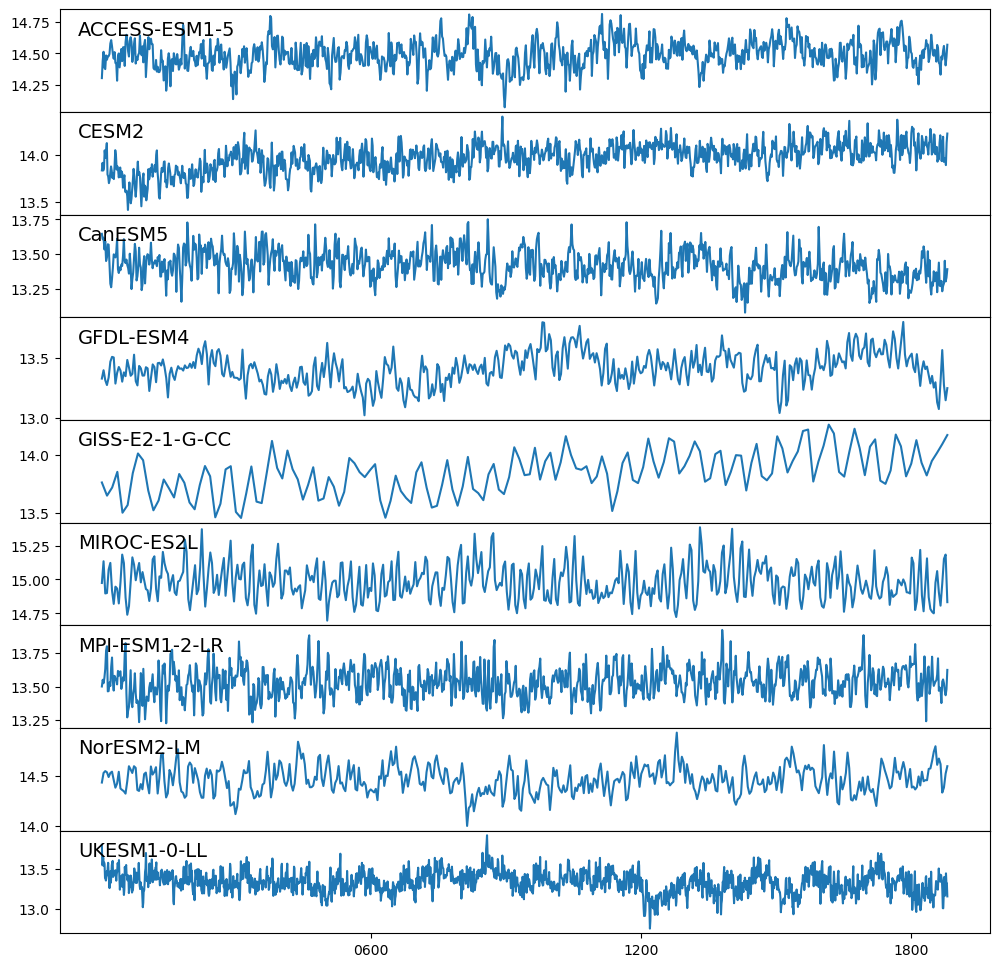

In [189]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(esmpi_smean_ds.model.values):
    ds = esmpi_smean_ds.sel(model=model)
    ax = axes[num]
    time = utils.convert_to_0_start_cftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    ax.annotate(model, xy=(0.02, 0.75), fontsize=14, xycoords='axes fraction')

- Connection to tcp://127.0.0.1:33200 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:43065', name: 1, status: running, memory: 77, processing: 52> (stimulus_id='handle-worker-cleanup-1710816093.8592374')
- Closing Nanny gracefully at 'tcp://127.0.0.1:45187'. Reason: worker-close
- Remove worker <WorkerState 'tcp://127.0.0.1:34447', name: 5, status: running, memory: 58, processing: 49> (stimulus_id='send-all-comm-fail-1710816093.8888283')
- Connection to tcp://127.0.0.1:33174 has been closed.
- Closing Nanny gracefully at 'tcp://127.0.0.1:42899'. Reason: worker-close
- Closing Nanny gracefully at 'tcp://127.0.0.1:33899'. Reason: worker-close
- Remove worker <WorkerState 'tcp://127.0.0.1:38379', name: 4, status: running, memory: 76, processing: 51> (stimulus_id='send-all-comm-fail-1710816093.9067283')
- Remove worker <WorkerState 'tcp://127.0.0.1:44573', name: 0, status: running, memory: 57, processing: 75> (stimulus_id='worker-send-comm-fail-1710816093.9068599')
- Connec

2024-03-19 13:41:33,823 - distributed.worker.state_machine - ERROR - Unhandled exception in async instruction for <Task finished name="execute(('where-8997a0125add8900fc9ed3b6afa615b5', 0, 1))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py", line 3638, in _finish_async_instruction
    stim = task.result()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py", line 3617, in wrapper
    with ledger.record(key="async-instruction"):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/contextlib.py", line 142, in __exit__
    next(self.gen)
  File "/g/data/hh5/public/apps/minicon

Error in callback <function _draw_all_if_interactive at 0x14ab8c114700> (for post_execute), with arguments args (),kwargs {}:


data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    handle._run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py", line 3653, in _finish_async_instruction
    self.handle_stimulus(stim)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker.py", line 219, in wrapper
    return method(self, *args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker.py", line 1937, in handle_stimulus
    super().handle_s

- Worker process 1738805 was killed by signal 2
- Worker process 1738789 was killed by signal 2
- Worker process 1738785 was killed by signal 2
- Worker process 1738782 was killed by signal 2



KeyboardInterrupt



- Worker process 1738793 was killed by signal 2
- Worker process 1738797 was killed by signal 2
- Worker process 1738803 was killed by signal 2
- Closing Nanny at 'tcp://127.0.0.1:33899'. Reason: nanny-close-gracefully
- Closing Nanny at 'tcp://127.0.0.1:42899'. Reason: nanny-close-gracefully
- Closing Nanny at 'tcp://127.0.0.1:45187'. Reason: nanny-close-gracefully
- Connection to tcp://127.0.0.1:33190 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:46747', name: 6, status: running, memory: 39, processing: 32> (stimulus_id='handle-worker-cleanup-1710816094.9746273')
- Task ('array-869e952ba5c3e328175f0236245d184c', 0, 0, 2, 0, 0) marked as failed because 4 workers died while trying to run it
- Connection to tcp://127.0.0.1:33154 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:33937', name: 3, status: running, memory: 25, processing: 55> (stimulus_id='handle-worker-cleanup-1710816095.0276992')
- Task ('array-33d748663db02905245dcc312adcc1f8', 0) marked as 

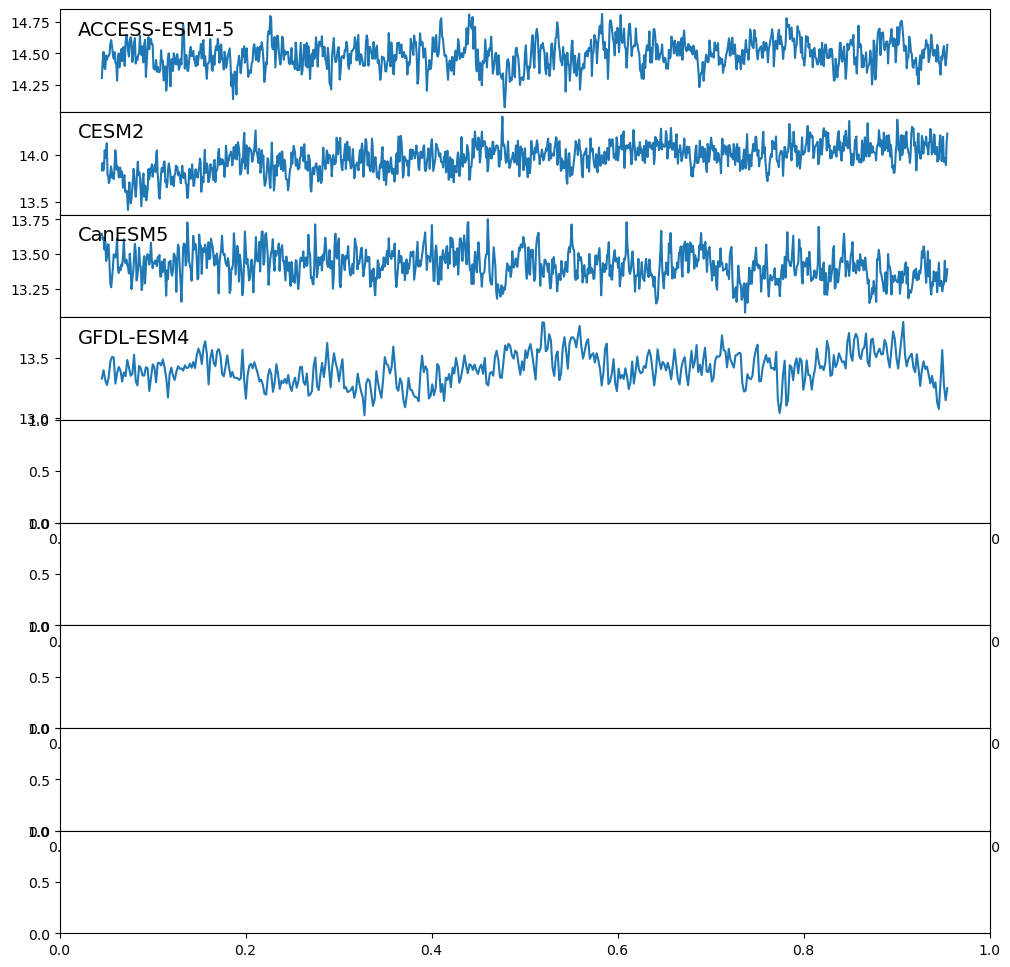

In [190]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(esmpi_smean_ds.model.values):
    ds = esmpi_smean_ds.sel(model=model)
    ax = axes[num]
    time = utils.convert_to_0_start_cftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    ax.annotate(model, xy=(0.02, 0.75), fontsize=14, xycoords='axes fraction')

In [ ]:
time = a1_smean_anom_xrlist['UKESM1-0-LL'].time.values
time_0_start = utils.convert_to_0_start_cftime(ds.time.values)

# Assuming your time_0_start is a list or array of cftime objects
min_year = min([date.year for date in time_0_start])
max_year = max([date.year for date in time_0_start[:101]])


# Create a list of years from min_year to max_year at 25-year intervals
years_25 = list(range(min_year, max_year+25, 25))
years_25 = np.array(years_25)-1
years_25

In [ ]:
ax.get_xticklabels()[0].get_text()# [0]

In [ ]:
[string.get_text().lstrip('0') for string in ax.get_xticklabels()]

In [ ]:
# Convert the years to cftime objects (you might need to adjust the cftime object type based on your data)
ticks = [cftime.DatetimeNoLeap(year, 1, 1) for year in years_25]

ncols = 2
nrows = int(np.ceil(len(a1_smean_anom_xrlist)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=.25, wspace=.15)
axes = [fig.add_subplot(gs[i]) for i in range(len(esmpi_smean_xrlist))]

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ds = ds.squeeze()#.values
    ax = axes[num]
    ax.plot(ds.time.values, ds.values)

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    
    # Manually set x-axis ticks and labels
    # ax.set_xticks(ticks)
    # ax.set_xticklabels(years_25)        
    # ax.set_yticks(np.arange(-0.5, 0.75, 0.25))
    # ax.set_ylim(-.75, .75)
    ax.set_xticklabels([string.get_text().lstrip('0') for string in ax.get_xticklabels()])
    ax.grid(True, linestyle='--', color='gray', alpha=0.2)
            
            
    #if len(ensembles) > 1: ax.legend(ncol=len(ensembles), loc='lower left')
    if num ==4: ax.set_ylabel('GMST '+r'($^\circ C$)' if variable == 'tas' else 'Precipitation (mm/day)', fontsize=15, rotation=90, labelpad=10)

    if num > 6: ax.set_xlabel('Time (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
variable

In [ ]:
# Convert the years to cftime objects (you might need to adjust the cftime object type based on your data)
ticks = [cftime.DatetimeNoLeap(year, 1, 1) for year in years_25]

ncols = 2
nrows = int(np.ceil(len(a1_smean_anom_xrlist)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=.15)
axes = [fig.add_subplot(gs[i]) for i in range(len(a1_smean_anom_xrlist))]

for num, (model, ds_multi_ens) in enumerate(a1_smean_anom_xrlist):
    ensembles = ds_multi_ens.ensemble.values
    for ens_number, ensemble in enumerate(ensembles):
        ds_vals = ds_multi_ens.sel(ensemble=ensemble).isel(time=slice(None, 101)).squeeze().values
        ax = axes[num]
        ax.plot(time_0_start[:len(ds_vals)], ds_vals, label=ensemble)

        if ens_number < 1: # Onlt want to these things once.
            ax.annotate(model, xy=(0.05, 0.85), fontsize=14, xycoords='axes fraction')
            ax.axhline(0, color='black', linewidth=1)
            ax.axvline(time_0_start[0], color='black', linewidth=1)
            # Manually set x-axis ticks and labels
            ax.set_xticks(ticks)
            ax.set_xticklabels(years_25)
            if variable == 'tas':
                yticks = np.arange(-0.5, 0.75, 0.25)
                ylims = (-.75, .75)
            elif variable == 'pr':
                ylims = (-.09, .09)
                step = 0.03
                yticks = np.arange(ylims[0]+step, ylims[1], step)
            ax.set_yticks(yticks)
            ax.set_ylim(ylims)
            ax.grid(True, linestyle='--', color='gray', alpha=0.2)
            
            
    if len(ensembles) > 1: ax.legend(ncol=len(ensembles), loc='lower left')
    if num ==4: ax.set_ylabel('GMST Anomaly '+r'($^\circ C$)' if variable == 'tas' else 'Precipitation Anomaly (mm/day)', fontsize=15, rotation=90, labelpad=10)

ax.set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
a1_smean_anom_xrlist.refkeys

In [ ]:
models_that_cool = [ 'CESM2', 'MPI-ESM1-2-LR', 'NorESM2-LM']

# [ 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
#                     'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM']

In [ ]:
# Convert the years to cftime objects (you might need to adjust the cftime object type based on your data)
ticks = [cftime.DatetimeNoLeap(year, 1, 1) for year in years_25]

ncols = 1
nrows = int(np.ceil(len(models_that_cool)/ncols))

fig = plt.figure(figsize=(6*ncols, 2.5*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.3, wspace=.15)
axes = [fig.add_subplot(gs[i]) for i in range(len(models_that_cool))]

for num, model in enumerate(models_that_cool):
    ds_multi_ens = a1_smean_anom_xrlist[model]
    ensembles = ds_multi_ens.ensemble.values
    ax = axes[num]
    #fig = plt.figure(figsize=(8, 4))
    #ax = fig.add_subplot(111)
    for ens_number, ensemble in enumerate(ensembles):
        ds_vals = ds_multi_ens.sel(ensemble=ensemble).isel(time=slice(None, 101)).squeeze().values
        
        ax.plot(time_0_start[:len(ds_vals)], ds_vals, label=ensemble)

        if ens_number < 1: # Onlt want to these things once.
            ax.annotate(model, xy=(0.05, 0.85), fontsize=14, xycoords='axes fraction')
            ax.axhline(0, color='black', linewidth=1)
            ax.axvline(time_0_start[0], color='black', linewidth=1)
            # Manually set x-axis ticks and labels
            ax.set_xticks(ticks)
            ax.set_xticklabels(years_25)
            if variable == 'tas':
                yticks = np.arange(-0.5, 0.75, 0.25)
                ylims = (-.75, .75)
            elif variable == 'pr':
                ylims = (-.09, .09)
                step = 0.03
                yticks = np.arange(ylims[0]+step, ylims[1], step)
            ax.set_yticks(yticks)
            ax.set_ylim(ylims)
            ax.grid(True, linestyle='--', color='gray', alpha=0.2)
            
            
    if len(ensembles) > 1: ax.legend(ncol=len(ensembles), loc='lower left')
    if num ==4: ax.set_ylabel('GMST Anomaly '+r'($^\circ C$)' if variable == 'tas' else 'Precipitation Anomaly (mm/day)', fontsize=15, rotation=90, labelpad=10)

ax.set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
# Convert the years to cftime objects (you might need to adjust the cftime object type based on your data)
ticks = [cftime.DatetimeNoLeap(year, 1, 1) for year in years_25]

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_multi_ens) in enumerate(a1_smean_anom_xrlist):
    ensembles = ds_multi_ens.ensemble.values
    for ens_number, ensemble in enumerate(ensembles):
        ds_vals = ds_multi_ens.sel(ensemble=ensemble).isel(time=slice(None, 101)).squeeze().values
        ax = axes[num]
        ax.plot(time_0_start[:len(ds_vals)], ds_vals, label=ensemble)

        if ens_number < 1: # Onlt want to these things once.
            ax.annotate(model, xy=(0.02, 0.75), fontsize=14, xycoords='axes fraction')
            
            # Manually set x-axis ticks and labels
            ax.set_xticks(ticks)
            ax.set_xticklabels(years_25)        
            ax.set_ylim(-.75, .75)
            ax.grid(True, linestyle='--', color='gray', alpha=0.2)
            
    if len(ensembles) > 1: ax.legend(ncol=len(ensembles), loc='best')
    if num ==4: ax.set_ylabel('GMST Anomaly '+r'($^\circ C$)', fontsize=15, rotation=90, labelpad=10)

ax.set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
fig = plt.figure(figsize=(len(esmpi_smean_xrlist)*1.25, 12))
gs = gridspec.GridSpec(len(esmpi_smean_xrlist), 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(len(esmpi_smean_xrlist))]

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = axes[num]
    time = utils.convert_to_0_start_cftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    ax.annotate(model, xy=(0.02, 0.75), fontsize=14, xycoords='axes fraction')

In [ ]:
models = esmpi_smean_xrlist.refkeys
ncols = 3; nrows = int(np.ceil(len(models)/2))

fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.6)

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = fig.add_subplot(gs[num])
    time = utils.convert_to_0_start_cftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.8)
    ax.set_title(model); ax.set_ylabel(r'GMST $(^\circ C)$'); ax.set_xlabel('Time after net zero emissions (years)')
    # ax.set_xlim([time[0], time[-1]])
    
    init_y = ds.squeeze().values
    x = np.arange(len(init_y))
    grad_yint = np.polyfit(x, init_y, deg=1)

    fitted_line = np.polyval(grad_yint, x)
    mk_val = pymannkendall.original_test(init_y)
    mk_pval = mk_val.p
    if mk_pval < 0.05:
        color = 'red'
        label = f'Gradient = {grad_yint[0]*50:.2f}' + r'$^\circ$C (50yr)$^{-1}$' + f'\np-value = {mk_pval:.3f}'
    else:
        color='grey'
        label=None
    
    ax.plot(time, fitted_line, linestyle='--', alpha=0.6, color=color, label=label)
    if mk_pval < 0.05: ax.legend(ncol=1, loc='best')#bbox_to_anchor=(0.6, 1.06))

- Register worker <WorkerState 'tcp://127.0.0.1:46045', name: 6, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46045
- Starting established connection to tcp://127.0.0.1:54848
- Register worker <WorkerState 'tcp://127.0.0.1:40311', name: 0, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:40311
- Starting established connection to tcp://127.0.0.1:54824
- Register worker <WorkerState 'tcp://127.0.0.1:40061', name: 2, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:40061
- Starting established connection to tcp://127.0.0.1:54838
- Register worker <WorkerState 'tcp://127.0.0.1:36369', name: 3, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:36369
- Starting established connection to tcp://127.0.0.1:54818


# Animation

In [ ]:
from PIL import Image

In [ ]:
SAVE_DIR = '/g/data/w40/ab2313/gifs/zec_nat_var_2'# '/gifs/natural_variability'

In [ ]:
ds = esmpi_smean_xrlist[1].isel(time=slice(0, 300)).chunk({'time':-1})
ds

In [ ]:
ds = ds.compute()

In [ ]:
bins;

In [ ]:
def plot_slice(ax, ds, slice):
    ds_sub = ds.isel(time=slice)
    ds_sub_mean = ds_sub.mean().values
    ax.plot(ds_sub.time.values, np.tile(ds_sub_mean, len(ds_sub.time.values)))
    return ds_sub_mean

In [ ]:
diff_list = []
for translation in range(len(ds.time.values)-50):
    print(f'{translation}, ', end='')
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 4))
    ds.plot(ax=ax1)
    mean1 = plot_slice(ax1, ds, slice(0+translation, 20+translation))
    mean2 = plot_slice(ax1, ds, slice(50+translation, 70+translation))
    number_name = '{:03d}'.format(translation) # MUst have leading zeros
    diff_list.append(mean2-mean1)
    hist, edges = np.histogram(diff_list, bins=bins)
    ax2.bar(edges[:-1], hist / len(ds.time.values), alpha=0.5, width=step) #, label=bar_label, color=bar_color)
    fig.savefig(os.path.join(SAVE_DIR, f'{number_name}.png'))
    plt.close()

In [ ]:
def save_gif(image_filenames,gif_filename):
  frames = []
  imgs = sorted(glob(image_filenames))
  for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
  
  frames[0].save(gif_filename, format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=100, loop=0)

In [ ]:
gif_filename = "rolling_picontrol_calc_4.gif"
save_gif(SAVE_DIR + "/*.png", os.path.join(SAVE_DIR, gif_filename))
print('Created ' + gif_filename)

# CO2 Time Series

In [ ]:
co2_path = '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/co2/gn/v20190429/*.nc'

In [ ]:
co2_da = xr.open_mfdataset(co2_path, chunks={'lat':-1, 'lon':-1, 'plev':-1, 'time':200})['co2']

In [ ]:
co2_da

In [ ]:
co2_mean_da = co2_da.mean(dim=['lat', 'lon', 'plev']).compute()

In [ ]:
co2_mean_da

In [ ]:
nubmer_iteratitions = 61

In [ ]:
co2_init = 280
linear_c02_values = [co2_init]
for i in range(1, nubmer_iteratitions):
    linear_c02_values.append(values[i]*1.01)

In [ ]:
start_year = co2_mean_da.time.values[0].year
start_year

In [ ]:
lienar_co2_times = xr.cftime_range(end=f'{start_year}-01-01', periods=nubmer_iteratitions, freq='1Y')

In [ ]:
np.where(lienar_co2_times.year == 1900)

In [ ]:
fig, ax = plt.subplots()
ax.plot(co2_mean_da.time.values, co2_mean_da.values, label='A1')
ax.plot(lienar_co2_times, linear_c02_values, label='1pct CO2')
ax.grid(True)
ax.set_ylabel('Atmospheric CO2 (ppm)')
ax.set_xticklabels([0, 50, 150, 250])
ax.legend()
ax.set_xlabel('Time After Simulation Start (years)')

In [ ]:
client.close()